# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [67]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [68]:
from functools import lru_cache

In [69]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [70]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [71]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

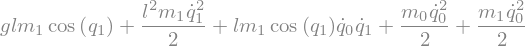

In [72]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [73]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = dynamicsymbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


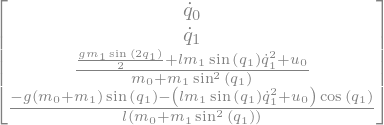

In [74]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

In [75]:
RHS_small.shape

In [76]:
RHS_d = RHS_small.diff(t)
RHS_d = simplify(RHS_d)

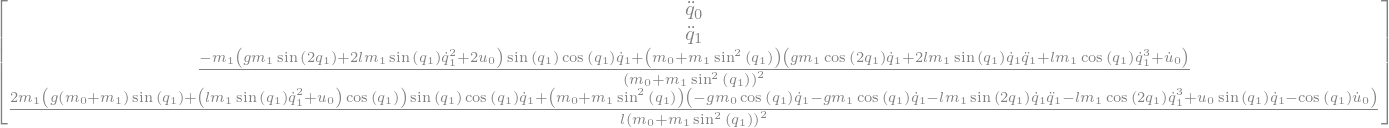

In [77]:
RHS_d

In [78]:
RHS_d_exp = RHS_small.copy()

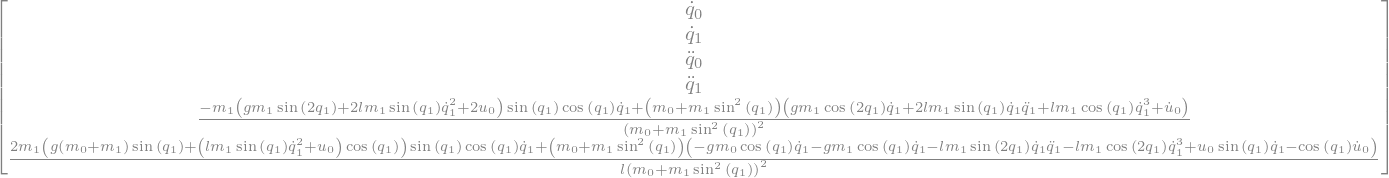

In [79]:
RHS_d_exp = Matrix([RHS_small[i] for i in [0,1]]+[RHS_d[i] for i in range(4)])
RHS_d_exp

In [80]:
q2 = dynamicsymbols('q_2')
q2d = q2.diff()
q2dd = q2d.diff()

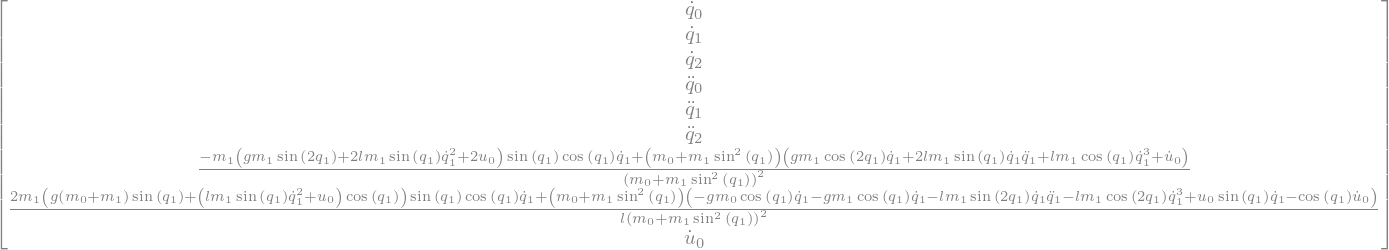

In [81]:
RHS_d_w = RHS_d_exp.row_insert(2, Matrix([q2d]))
RHS_d_w = RHS_d_w.row_insert(5, Matrix([q2dd]))
RHS_d_w = RHS_d_w.row_insert(8, Matrix([u0.diff()]))
RHS_d_w

In [82]:
RHS_d_w.shape

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [83]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [84]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

In [85]:
@lru_cache(maxsize=None)
def casadi_cartpole_prim(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _opti.initial_guess([0,0], [1,np.pi])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [86]:
_res = casadi_cartpole_prim('hs_mod_parab',25, 'lin', solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Explicit Lagranges Method
Generating F function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]

Generating G function
x vars expected: [q_0, q_1, v_0, v_1]
x vars found: [q_1, v_0, v_1]
u vars found: [u_0]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	q: [q_0, q_1]
	v: [v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1670
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      255

Total number of variables............

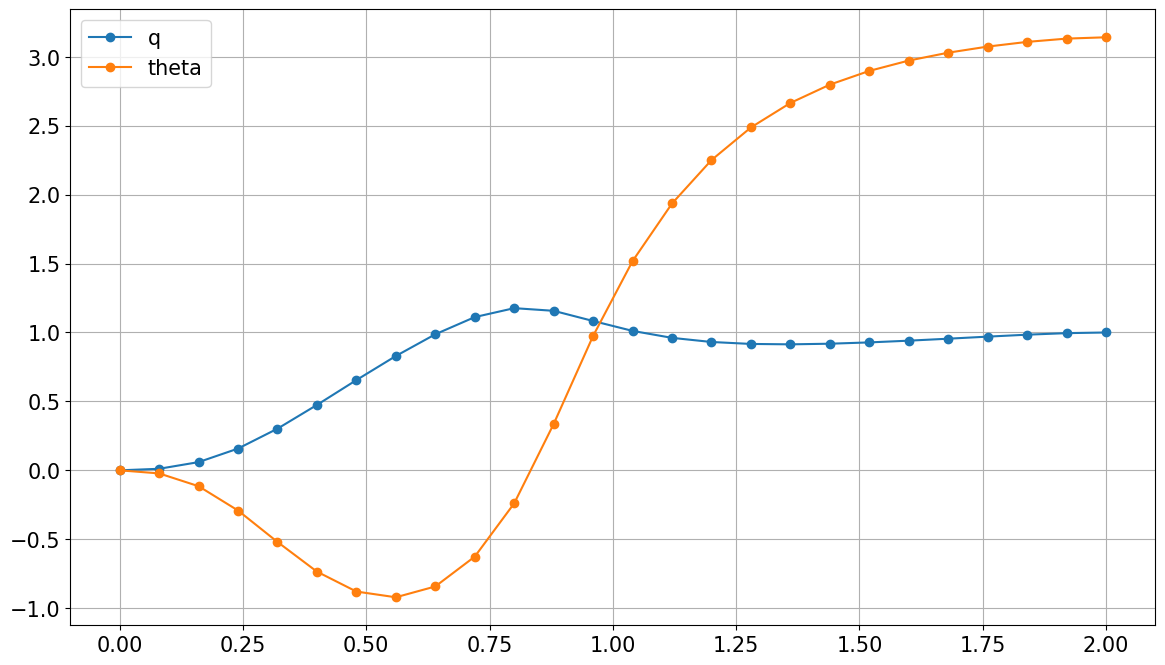

In [87]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', label = labels[ii])
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

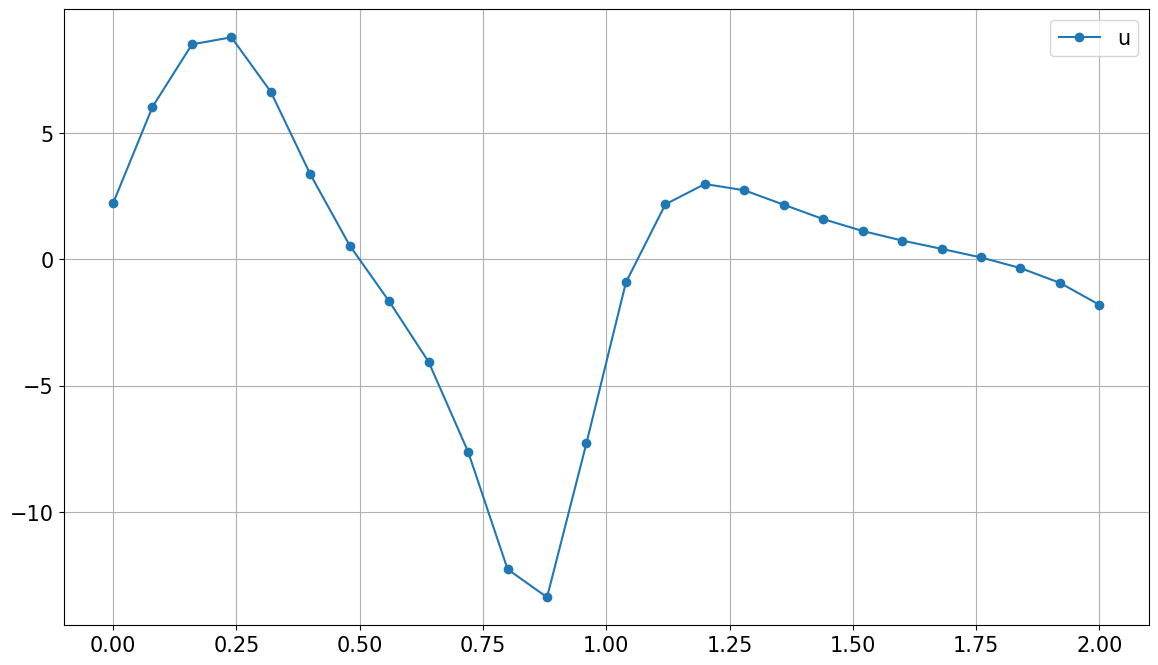

In [88]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:], marker = 'o', label = 'u')
#    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + ' u_c')
plt.grid()
plt.legend()

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [89]:
from chords.casadi import implicit_dynamic_x_to_casadi_function

In [90]:
x = dynamicsymbols('x_0:9')

In [91]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [92]:
RHSx=RHS_d_w.subs([
    [u0.diff(), u1],
    [u0, x[8]],
    [q0.diff(t,2), x[6]],
    [q1.diff(t,2), x[7]],
    [q2.diff(t,2), x[8]],
    [q0.diff(t), x[3]],
    [q1.diff(t), x[4]],
    [q2.diff(t), x[5]],
    [q0, x[0]],
    [q1, x[1]],
    [q2, x[2]]
])

RHS_d_w

RHSx

RHS_small

In [93]:
x_d_mat = Matrix(x_d)

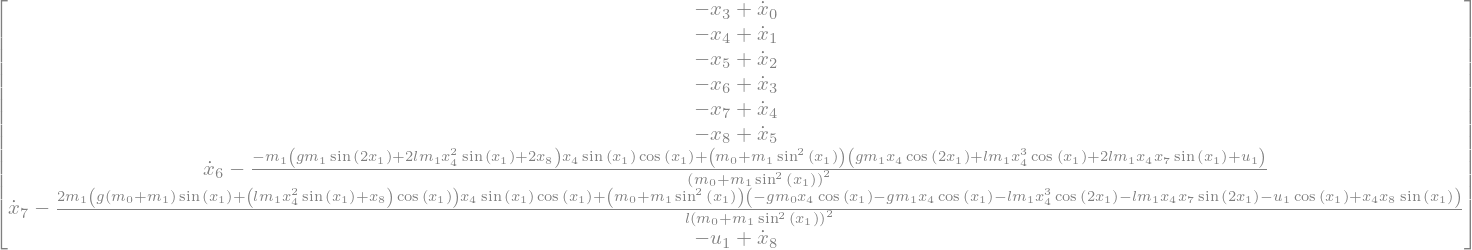

In [94]:
impl_D = x_d_mat-RHSx
impl_D

In [95]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot]
u vars found: [u_1]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
	u: [u_1]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[9],x_dot[9],u,lambdas[0],params[4])->(residue[1x9]) MXFunction)

In [96]:
from chords.piecewise import interpolated_array, interpolated_array_derivative, reduce_F, hs_accel_restr
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy, Sym2Fx
from chords.casadi import rhs_to_casadi_function
import casadi as cas

In [97]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



F_nump_w = RHS2numpy(RHSx, 2)

In [98]:
G_nump = reduce_F(F_nump)

In [99]:
F_nump_w = Sym2Fx(RHSx, x, None, verbose=True)

x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot]
x vars found: [x_1, x_3, x_4, x_5, x_6, x_7, x_8]
u vars found: [u_1]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
	u: [u_1]
	params: [g, l, m_0, m_1]



In [100]:
F_cas = rhs_to_casadi_function(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [101]:
G_cas = reduce_F(F_cas, mode='casadi')

def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[8]
    x = cas.horzcat(q,v)
    f = F_cas(x, u, params)
    g = f[:, 2:]
    opti.subject_to(a == g)

In [102]:
def initial_cond_g(_op):
    X_s = _op.opti_points['x_s']
    opti = _op.opti
    a = X_s[:,6:8]
    q = X_s[:,:2]
    v = X_s[:,3:5]
    u = X_s[:,8]
    g = G_cas(q, v, u, params)
    opti.subject_to(a == g)

In [149]:
N = 35
scheme = 'trapz'

_op = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )


_op.dynamic_setup('f_x_impl', 3, 1, order=3)
_op.opti_setup(N)
_op.initial_guess([0,0,0], [1,np.pi,0])
#_op.sq_cost(_op.opti_arrs['x'][:,8], _op.opti_arrs['x_c'][:,8])
_op.u_sq_cost()
_op.apply_scheme()


opti = _op.opti
X = _op.opti_arrs['x']
U = _op.opti_arrs['u']
X_s = _op.opti_points['x_s']
X_e = _op.opti_points['x_e']

Q_s = X_s[:,:2]
V_s = X_s[:,3:5]
Q_e = X_e[:,:2]
V_e = X_e[:,3:5]
N = _op.N

# Initial and final conditions
opti.subject_to(Q_s.T == [0, 0])
opti.subject_to(Q_e.T == [1, np.pi])
opti.subject_to(V_s.T == [0, 0])
opti.subject_to(V_e.T == [0, 0])
initial_cond_g(_op)

# Appliying restrictions and action boundaries
u_m = 100
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

_op.chrono_solve(solve_repetitions=2,)

_res = _op.results

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     2212
Number of nonzeros in inequality constraint Jacobian.:       36
Number of nonzeros in Lagrangian Hessian.............:      324

Total number of variables............................:      684
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      649
Total number of inequality constraints...............:       36
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       36
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+01 0.00e+00  -1.0 0.00e

 107r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.4 1.00e+00 3.73e-09f 29
 108r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.9 1.00e+00 3.73e-09f 29
 109r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.8 1.00e+00 7.45e-09f 28
 111r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 1.00e+00w  1
 112r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.48e-06 -17.9 1.00e+00 1.00e+00w  1
 113r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.29e-06 -16.6 1.00e+00 1.00e+00w  1
 114r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.94e-06 -17.0 1.00e+00 1.00e+00s 21
 115r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.13e-04 -17.5 0.00e+00 0.00e+00R  1
 116r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 7.45e-09f 28
 117r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 3.73e-09f 29
 118r 2.4579566e+03 3.81e-06

 239r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.55e-05    -  1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.55e-05    -  1.00e+00 1.86e-09f 30
 241r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.55e-05    -  1.00e+00 3.73e-09f 29
 242r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 1.86e-09f 30
 243r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.71e-04    -  1.00e+00 3.73e-09f 29
 244r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.15e-06 -17.3 1.00e+00 1.86e-09f 30
 245r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.25e-06 -17.8 1.00e+00 3.73e-09f 29
 246r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.82e-06    -  1.00e+00 7.45e-09f 28
 247r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.55e-05    -  1.00e+00 3.73e-09f 29
 248r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 7.55e-05    -  1.00e+00 1.00e+00w  1
 249r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.12e-05 -17.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

 376r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.91e-06    -  1.00e+00 1.00e+00w  1
 377r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.36e-06    -  1.00e+00 1.00e+00s 21
 378r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.69e-05 -17.8 0.00e+00 0.00e+00R  1
 379r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.43e-05 -17.4 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.50e-05    -  1.00e+00 1.86e-09f 30
 381r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.50e-05    -  1.00e+00 3.73e-09f 29
 382r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.44e-05 -17.9 1.00e+00 1.86e-09f 30
 383r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.45e-05 -17.4 1.00e+00 1.86e-09f 30
 384r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.45e-05 -17.0 1.00e+00 1.86e-09f 30
 385r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.45e-05 -17.5 1.00e+00 1.86e-09f 30
 386r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.95e-05 -18.0 1.00e+00 9.31e-10f 31
 387r 2.4579566e+03 7.63e-06

 496r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.44e-06 -17.6 1.00e+00 1.86e-09f 30
 497r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -18.1 1.00e+00 3.73e-09f 29
 498r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
 499r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.7 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.63e-06 -17.3 1.00e+00 1.00e+00w  1
 501r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.80e-06 -17.8 1.00e+00 1.00e+00w  1
 502r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 5.98e-06    -  1.00e+00 1.00e+00w  1
 503r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.69e-05    -  1.00e+00 1.00e+00s 21
 504r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.69e-06 -18.2 1.00e+00 1.00e+00s 21
 505r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 6.25e-06 -16.9 0.00e+00 0.00e+00R  1
 506r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
 507r 2.4579566e+03 7.63e-06

 628r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.10e-05    -  1.00e+00 1.00e+00w  1
 629r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.83e-06 -18.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 3.56e-06    -  1.00e+00 1.00e+00s 21
 631r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.10e-05    -  0.00e+00 0.00e+00R  1
 632r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.26e-06 -19.2 1.00e+00 1.86e-09f 30
 633r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 9.58e-06 -19.7 1.00e+00 9.31e-10f 31
 634r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 4.12e-05 -20.0 1.00e+00 1.86e-09f 30
 635r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.59e-05 -19.1 1.00e+00 1.86e-09f 30
 636r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.01e-05 -19.6 1.00e+00 1.86e-09f 30
 637r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.19e-05 -19.1 1.00e+00 1.86e-09f 30
 638r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 9.87e-06 -19.6 1.00e+00 1.86e-09f 30
 639r 2.4579566e+03 7.63e-06

 754r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 1.50e-05 -18.3 1.00e+00 1.00e+00w  1
 755r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.73e-05 -18.8 1.00e+00 1.00e+00s 21
 756r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.29e-05    -  0.00e+00 0.00e+00R  1
 757r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -18.3 1.00e+00 9.31e-10f 31
 758r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.0 1.00e+00 9.31e-10f 31
 759r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -16.6 1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.1 1.00e+00 9.31e-10f 31
 761r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.5 1.00e+00 9.31e-10f 31
 762r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -18.0 1.00e+00 9.31e-10f 31
 763r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -18.5 1.00e+00 9.31e-10f 31
 764r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -19.0 1.00e+00 9.31e-10f 31
 765r 2.4579566e+03 1.53e-05

 879r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -15.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 1.71e-05 -16.4 1.00e+00 1.00e+00w  1
 881r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.99e-06 -16.9 1.00e+00 1.00e+00w  1
 882r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.01e-05    -  1.00e+00 1.00e+00s 21
 883r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.45e-05 -17.4 1.00e+00 1.00e+00s 21
 884r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 9.80e-06 -16.9 0.00e+00 0.00e+00R  1
 885r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.4 1.00e+00 7.45e-09f 28
 886r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.23e-05 -17.9 1.00e+00 3.73e-09f 29
 887r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -18.4 1.00e+00 1.86e-09f 30
 888r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.40e-05 -17.0 1.00e+00 1.86e-09f 30
 889r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.59e-05 -17.5 1.00e+00 1.86e-09f 30
iter    objective    inf_pr 

 993r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.33e-06    -  1.00e+00 1.00e+00s 21
 994r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.70e-05 -17.9 0.00e+00 0.00e+00R  1
 995r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.90e-06 -17.5 1.00e+00 3.73e-09f 29
 996r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.59e-06 -18.0 1.00e+00 3.73e-09f 29
 997r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
 998r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
 999r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1001r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 9.31e-10f 31
1002r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.15e-05 -18.5 1.00e+00 1.86e-09f 30
1003r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1004r 2.4579566e+03 7.63e-06

1121r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.3 1.00e+00 9.31e-10f 31
1122r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -16.9 1.00e+00 3.73e-09f 29
1123r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.4 1.00e+00 3.73e-09f 29
1124r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1125r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1126r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1127r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.00e+00w  1
1128r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.39e-06 -17.9 1.00e+00 1.00e+00w  1
1129r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.46e-06 -17.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.58e-06 -17.0 1.00e+00 1.00e+00s 21
1131r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.33e-06 -17.5 1.00e+00 1.00e+00s 21
1132r 2.4579566e+03 7.63e-06

1254r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.3 1.00e+00 9.31e-10f 31
1255r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.27e-05    -  1.00e+00 4.66e-10f 32
1256r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.8 1.00e+00 1.16e-10f 34
1257r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.81e-05 -17.4 1.00e+00 5.82e-11f 35
1258r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.53e-05 -17.0 1.00e+00 1.00e+00w  1
1259r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.50e-03    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 8.79e-04 -17.4 1.00e+00 1.00e+00w  1
1261r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 3.85e-04 -17.9 1.00e+00 1.00e+00s 21
1262r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 2.50e-03    -  0.00e+00 0.00e+00R  1
1263r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.10e-05 -17.5 1.00e+00 9.31e-10f 31
1264r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.74e-06 -18.0 1.00e+00 9.31e-10f 31
1265r 2.4579566e+03 7.63e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.76e-05    -  1.00e+00 3.73e-09f 29
1371r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1372r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.76e-05    -  1.00e+00 1.86e-09f 30
1373r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1374r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.76e-05    -  1.00e+00 9.31e-10f 31
1375r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.70e-04    -  1.00e+00 1.86e-09f 30
1376r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.76e-05    -  1.00e+00 1.86e-09f 30
1377r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 9.31e-10f 31
1378r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.76e-05    -  1.00e+00 2.33e-10f 33
1379r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380r 2.4579566e+03 7.63e-06

1492r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.51e-06    -  1.00e+00 3.73e-09f 29
1493r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.49e-06    -  1.00e+00 3.73e-09f 29
1494r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.49e-06    -  1.00e+00 1.86e-09f 30
1495r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.49e-06    -  1.00e+00 1.86e-09f 30
1496r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.49e-06    -  1.00e+00 1.86e-09f 30
1497r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.49e-06    -  1.00e+00 1.86e-09f 30
1498r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.53e-06    -  1.00e+00 3.73e-09f 29
1499r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.51e-06    -  1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.51e-06    -  1.00e+00 3.73e-09f 29
1501r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.51e-06    -  1.00e+00 1.00e+00w  1
1502r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.37e-06 -17.4 1.00e+00 1.00e+00w  1
1503r 2.4579566e+03 1.91e-06

1615r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.3 1.00e+00 1.86e-09f 30
1616r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.8 1.00e+00 1.00e+00w  1
1617r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.73e-06 -17.4 1.00e+00 1.00e+00w  1
1618r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.59e-05 -17.9 1.00e+00 1.00e+00w  1
1619r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.38e-05 -18.4 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.77e-06 -18.9 0.00e+00 0.00e+00R  1
1621r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.46e-06 -17.5 1.00e+00 7.45e-09f 28
1622r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.0 1.00e+00 3.73e-09f 29
1623r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -15.8 1.00e+00 3.73e-09f 29
1624r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.3 1.00e+00 1.86e-09f 30
1625r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.7 1.00e+00 3.73e-09f 29
1626r 2.4579566e+03 3.81e-06

1741r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.88e-06 -17.2 1.00e+00 3.73e-09f 29
1742r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.7 1.00e+00 9.31e-10f 31
1743r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.55e-06 -18.1 1.00e+00 3.73e-09f 29
1744r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.84e-06 -16.8 1.00e+00 3.73e-09f 29
1745r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.89e-06 -17.3 1.00e+00 7.45e-09f 28
1746r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.8 1.00e+00 3.73e-09f 29
1747r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.89e-06 -17.3 1.00e+00 4.66e-10h 32
1748r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.8 1.00e+00 1.00e+00w  1
1749r 2.4579566e+03 1.91e-06 1.14e-13  -8.1 5.07e-06 -18.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.44e-06 -18.8 1.00e+00 1.00e+00w  1
1751r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.34e-06 -18.3 1.00e+00 1.00e+00s 21
1752r 2.4579566e+03 3.81e-06

1864r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.23e-06 -16.6 0.00e+00 0.00e+00R  1
1865r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 4.64e-06 -15.3 1.00e+00 2.98e-08f 26
1866r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 4.65e-06 -15.7 1.00e+00 2.98e-08f 26
1867r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.86e-06 -16.2 1.00e+00 2.98e-08f 26
1868r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.86e-05    -  1.00e+00 1.49e-08f 27
1869r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 6.05e-06 -16.7 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 6.23e-06 -17.2 1.00e+00 1.19e-07f 24
1871r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.58e-06 -16.7 1.00e+00 2.98e-08f 26
1872r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 2.06e-05 -17.2 1.00e+00 2.98e-08f 26
1873r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 9.61e-06 -16.8 1.00e+00 7.45e-09h 28
1874r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 2.06e-05    -  1.00e+00 1.00e+00s 64
1875r 2.4579566e+03 1.53e-05

1986r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.1 1.00e+00 1.49e-08f 27
1987r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.77e-05 -17.6 1.00e+00 1.49e-08f 27
1988r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -18.1 1.00e+00 1.49e-08f 27
1989r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.65e-05 -16.8 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.85e-05    -  1.00e+00 7.45e-09f 28
1991r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.80e-05 -16.3 1.00e+00 7.45e-09f 28
1992r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.95e-05 -16.8 1.00e+00 1.49e-08f 27
1993r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.57e-05 -16.4 1.00e+00 7.45e-09f 28
1994r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.45e-05    -  1.00e+00 9.31e-10f 31
1995r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.69e-05 -16.9 1.00e+00 2.33e-10h 33
1996r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.54e-05 -16.4 1.00e+00 1.00e+00w  1
1997r 2.4579566e+03 3.81e-06

2103r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.53e-05 -16.2 1.00e+00 1.49e-08f 27
2104r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -16.7 1.00e+00 1.49e-08f 27
2105r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.75e-05    -  1.00e+00 1.49e-08f 27
2106r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.2 1.00e+00 3.73e-09f 29
2107r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.30e-04 -17.6 1.00e+00 1.86e-09f 30
2108r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05    -  1.00e+00 4.66e-10h 32
2109r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.36e-04 -17.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2110r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 2.35e-04    -  1.00e+00 1.00e+00w  1
2111r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 4.75e-04 -17.7 1.00e+00 1.00e+00w  1
2112r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.60e-04 -18.2 1.00e+00 1.00e+00s 21
2113r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.35e-04    -  0.00e+00 0.00e+00R  1
2114r 2.4579566e+03 1.53e-05

2221r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 1.20e-05 -18.0 1.00e+00 1.00e+00w  1
2222r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 1.97e-05 -16.6 1.00e+00 1.00e+00s 21
2223r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 8.34e-06 -15.3 0.00e+00 0.00e+00R  1
2224r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.61e-05 -15.8 1.00e+00 7.45e-09f 28
2225r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -16.3 1.00e+00 7.45e-09f 28
2226r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -16.8 1.00e+00 7.45e-09f 28
2227r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 5.95e-04 -17.2 1.00e+00 7.45e-09f 28
2228r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 9.45e-05    -  1.00e+00 7.45e-09f 28
2229r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 5.08e-05    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.05e-04    -  1.00e+00 7.45e-09f 28
2231r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 8.33e-05    -  1.00e+00 7.45e-09f 28
2232r 2.4579566e+03 1.53e-05

2339r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.95e-06 -16.6 1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.63e-05    -  1.00e+00 1.49e-08f 27
2341r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.71e-06 -17.1 1.00e+00 1.49e-08f 27
2342r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -16.7 1.00e+00 5.96e-08f 25
2343r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.17e-05    -  1.00e+00 5.96e-08f 25
2344r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.46e-05    -  1.00e+00 1.49e-08f 27
2345r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 1.11e-05    -  1.00e+00 3.73e-09h 29
2346r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.24e-06 -17.2 1.00e+00 1.00e+00s 64
2347r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 2.79e-06 -16.7 0.00e+00 0.00e+00R  1
2348r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 6.80e-06 -17.2 1.00e+00 2.98e-08f 26
2349r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 4.24e-06 -17.7 1.00e+00 2.98e-08f 26
iter    objective    inf_pr 

2458r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -17.5 1.00e+00 1.00e+00s 64
2459r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 2.42e-06 -17.0 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2460r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.6 1.00e+00 2.38e-07f 23
2461r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 2.14e-06 -17.1 1.00e+00 5.96e-08f 25
2462r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.7 1.00e+00 3.73e-09h 29
2463r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.2 1.00e+00 2.33e-10h 33
2464r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.7 1.00e+00 1.16e-10h 34
2465r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 8.09e-06 -16.3 1.00e+00 5.82e-11h 35
2466r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.8 1.00e+00 2.91e-11h 36
2467r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 1.91e-06 -16.3 1.00e+00 7.45e-09h 28
2468r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 3.99e-06    -  1.00e+00 2.33e-10h 33
2469r 2.4579566e+03 1.91e-06

2583r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 8.94e-06 -16.8 0.00e+00 0.00e+00R  1
2584r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.2 1.00e+00 7.45e-09f 28
2585r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -16.8 1.00e+00 7.45e-09f 28
2586r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.64e-05 -16.4 1.00e+00 7.45e-09f 28
2587r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 4.09e-04 -16.9 1.00e+00 7.45e-09f 28
2588r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.57e-05 -16.4 1.00e+00 7.45e-09f 28
2589r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.99e-05 -16.9 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -16.5 1.00e+00 7.45e-09f 28
2591r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.12e-05 -17.0 1.00e+00 7.45e-09f 28
2592r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.5 1.00e+00 7.45e-09f 28
2593r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 9.91e-05 -17.0 1.00e+00 1.49e-08f 27
2594r 2.4579566e+03 7.63e-06

2706r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.51e-05    -  1.00e+00 7.45e-09f 28
2707r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.1 1.00e+00 7.45e-09f 28
2708r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.23e-05 -17.6 1.00e+00 7.45e-09f 28
2709r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.84e-05    -  1.00e+00 7.45e-09f 28
2711r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 5.77e-05 -17.2 1.00e+00 1.00e+00w  1
2712r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.43e-04 -17.6 1.00e+00 1.00e+00w  1
2713r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.63e-04 -17.2 1.00e+00 1.00e+00w  1
2714r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.86e-04    -  1.00e+00 1.00e+00s 21
2715r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.33e-05 -17.7 1.00e+00 1.00e+00s 21
2716r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.75e-05 -16.4 1.00e+00 1.00e+00s 21
2717r 2.4579566e+03 7.63e-06

2834r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.17e-05 -16.4 1.00e+00 1.49e-08f 27
2835r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.49e-04 -16.9 1.00e+00 1.49e-08f 27
2836r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.63e-05 -17.3 1.00e+00 7.45e-09f 28
2837r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.58e-05 -16.9 1.00e+00 3.73e-09f 29
2838r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 9.78e-05 -17.4 1.00e+00 1.86e-09f 30
2839r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 5.63e-05 -17.9 1.00e+00 9.31e-10h 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2840r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.17e-04    -  1.00e+00 1.00e+00w  1
2841r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 3.91e-05    -  1.00e+00 1.00e+00w  1
2842r 2.4579566e+03 7.63e-06 6.82e-13  -7.2 1.55e-05 -18.3 1.00e+00 1.00e+00w  1
2843r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.36e-05 -17.0 1.00e+00 1.00e+00s 21
2844r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 3.91e-05    -  1.00e+00 1.00e+00s 21
2845r 2.4579566e+03 7.63e-06

2944r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 2.82e-06 -16.5 1.00e+00 1.00e+00s 21
2945r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 6.78e-06    -  1.00e+00 1.00e+00s 21
2946r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.21e-06 -16.9 0.00e+00 0.00e+00R  1
2947r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -16.5 1.00e+00 5.96e-08f 25
2948r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 5.96e-06    -  1.00e+00 2.98e-08f 26
2949r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 8.46e-06    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2950r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 7.70e-06 -17.0 1.00e+00 7.45e-09f 28
2951r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -16.6 1.00e+00 3.73e-09h 29
2952r 2.4579566e+03 1.91e-06 5.68e-13  -7.2 3.82e-06 -17.0 1.00e+00 1.00e+00s 65
2953  2.4579566e+03 1.91e-06 9.68e+00  -8.6 9.88e-02 -14.1 1.00e+00 1.91e-06h 20
2954  2.4579566e+03 1.53e-05 3.23e-04  -8.6 1.44e+00 -13.7 1.00e+00 1.00e+00s 22
2955  2.4579566e+03 1.53e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3080r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 1.76e-05 -11.6 1.00e+00 1.00e+00s 21
3081r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 9.39e-06 -12.1 1.00e+00 1.00e+00s 21
3082r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 8.65e-06 -12.6 0.00e+00 0.00e+00R  1
3083r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.09e-05    -  1.00e+00 1.86e-09f 30
3084r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -13.1 1.00e+00 9.31e-10f 31
3085r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.80e-02    -  1.00e+00 1.86e-09f 30
3086r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -13.5 1.00e+00 1.86e-09f 30
3087r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -14.0 1.00e+00 1.86e-09f 30
3088r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.77e-02    -  1.00e+00 1.86e-09f 30
3089r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -14.5 1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3090r 2.4579566e+03 1.53e-05

3208r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -14.0 1.00e+00 1.86e-09f 30
3209r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -14.5 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3210r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -15.0 1.00e+00 9.31e-10f 31
3211r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -15.5 1.00e+00 9.31e-10f 31
3212r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -15.9 1.00e+00 1.86e-09f 30
3213r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.86e-05    -  1.00e+00 9.31e-10f 31
3214r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.29e-05    -  1.00e+00 1.00e+00w  1
3215r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.51e-05 -16.4 1.00e+00 1.00e+00w  1
3216r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.00e-05 -16.9 1.00e+00 1.00e+00w  1
3217r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.29e-04    -  1.00e+00 1.00e+00s 21
3218r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.14e-03 -17.4 0.00e+00 0.00e+00R  1
3219r 2.4579566e+03 1.53e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3340r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.01e-04 -18.4 1.00e+00 9.31e-10f 31
3341r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.69e-02 -18.0 1.00e+00 4.66e-10f 32
3342r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.41e-04 -18.5 1.00e+00 5.82e-11h 35
3343r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 7.56e-05 -18.0 1.00e+00 1.46e-11h 37
3344r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 2.81e-05 -17.6 1.00e+00 1.00e+00w  1
3345r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.22e-05 -18.1 1.00e+00 1.00e+00w  1
3346r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 1.36e-05 -17.6 1.00e+00 1.00e+00w  1
3347r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.70e-05 -16.3 1.00e+00 1.00e+00s 21
3348r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 5.37e-06 -16.8 0.00e+00 0.00e+00R  1
3349r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.18e-05 -17.3 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3350r 2.4579566e+03 7.63e-06

3457r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.07e-05    -  1.00e+00 3.73e-09f 29
3458r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.07e-05    -  1.00e+00 1.86e-09f 30
3459r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.01e-05 -18.4 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3460r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.39e-05 -17.9 1.00e+00 9.31e-10f 31
3461r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.75e-05 -18.4 1.00e+00 3.73e-09f 29
3462r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.07e-05    -  1.00e+00 3.73e-09f 29
3463r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.07e-05    -  1.00e+00 3.73e-09f 29
3464r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.59e-03 -18.9 1.00e+00 1.86e-09f 30
3465r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.07e-05    -  1.00e+00 9.31e-10f 31
3466r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 8.20e-04    -  1.00e+00 1.00e+00w  1
3467r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.83e-05 -16.7 1.00e+00 1.00e+00w  1
3468r 2.4579566e+03 1.53e-05

3588r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.90e-05    -  1.00e+00 1.86e-09f 30
3589r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.07e-05    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3590r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 4.56e-03 -17.7 1.00e+00 2.33e-10f 33
3591r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.67e-05    -  1.00e+00 1.16e-10f 34
3592r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 5.27e-04    -  1.00e+00 5.82e-11h 35
3593r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.76e-05    -  1.00e+00 1.00e+00w  1
3594r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.98e-05 -17.3 1.00e+00 1.00e+00w  1
3595r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.02e-05    -  1.00e+00 1.00e+00w  1
3596r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.25e-05    -  1.00e+00 1.00e+00s 21
3597r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 6.54e-03 -17.8 0.00e+00 0.00e+00R  1
3598r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.94e-05 -17.3 1.00e+00 9.31e-10f 31
3599r 2.4579566e+03 1.53e-05

3719r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 2.27e-05 -16.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3720r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 3.02e-05    -  1.00e+00 1.00e+00w  1
3721r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.36e-04 -16.5 1.00e+00 1.00e+00w  1
3722r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 1.75e-05 -17.0 1.00e+00 1.00e+00s 21
3723r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 3.02e-05    -  0.00e+00 0.00e+00R  1
3724r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 2.44e-04 -17.5 1.00e+00 3.73e-09f 29
3725r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 7.17e-04 -17.9 1.00e+00 3.73e-09f 29
3726r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 6.18e-05    -  1.00e+00 3.73e-09f 29
3727r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.56e-05 -18.0 1.00e+00 3.73e-09f 29
3728r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.75e-05 -16.7 1.00e+00 3.73e-09f 29
3729r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.53e-05 -17.1 1.00e+00 3.73e-09f 29
iter    objective    inf_pr 

3837r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.67e-05 -17.4 1.00e+00 3.73e-09f 29
3838r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.57e-05    -  1.00e+00 3.73e-09f 29
3839r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.29e-05    -  1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3840r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.23e-05 -17.9 1.00e+00 3.73e-09f 29
3841r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.81e-05    -  1.00e+00 3.73e-09f 29
3842r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.46e-05 -18.3 1.00e+00 1.00e+00w  1
3843r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.17e-05 -17.0 1.00e+00 1.00e+00w  1
3844r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 2.12e-05 -16.6 1.00e+00 1.00e+00w  1
3845r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 3.68e-05    -  1.00e+00 1.00e+00s 21
3846r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.36e-05 -17.1 1.00e+00 1.00e+00s 21
3847r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.36e-05 -17.5 0.00e+00 0.00e+00R  1
3848r 2.4579566e+03 7.63e-06

3963r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 2.27e-05 -17.3 1.00e+00 7.45e-09f 28
3964r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.13e-05 -17.8 1.00e+00 3.73e-09h 29
3965r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.03e-05 -17.3 1.00e+00 1.00e+00w  1
3966r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.97e-05    -  1.00e+00 1.00e+00w  1
3967r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.50e-05 -16.9 1.00e+00 1.00e+00w  1
3968r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 3.97e-05    -  1.00e+00 1.00e+00s 21
3969r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.97e-05    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3970r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 5.93e-05 -17.4 1.00e+00 3.73e-09f 29
3971r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.32e-05 -17.9 1.00e+00 3.73e-09f 29
3972r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 9.17e-06 -16.5 1.00e+00 3.73e-09f 29
3973r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.27e-05 -17.0 1.00e+00 3.73e-09f 29
3974r 2.4579566e+03 7.63e-06

4089r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 3.56e-05 -17.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4090r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.26e-05 -17.3 1.00e+00 1.00e+00w  1
4091r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 7.15e-05    -  1.00e+00 1.00e+00s 21
4092r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.95e-05 -16.8 1.00e+00 1.00e+00s 21
4093r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.54e-05 -16.4 0.00e+00 0.00e+00R  1
4094r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 5.60e-05    -  1.00e+00 1.86e-09f 30
4095r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 4.83e-05 -16.9 1.00e+00 3.73e-09f 29
4096r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.40e-05 -16.5 1.00e+00 3.73e-09f 29
4097r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 8.80e-05    -  1.00e+00 3.73e-09f 29
4098r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.52e-05 -17.0 1.00e+00 3.73e-09f 29
4099r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 6.47e-04 -17.4 1.00e+00 3.73e-09f 29
iter    objective    inf_pr 

4207  2.4579566e+03 3.81e-06 8.53e-13  -8.6 3.38e-06 -13.1 1.00e+00 1.00e+00h  1
4208  2.4579566e+03 1.53e-05 2.02e-06  -8.6 1.87e+04    -  1.00e+00 1.00e+00h  1
4209  2.4579566e+03 1.53e-05 1.01e-06  -8.6 1.14e-05 -12.7 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4210  2.4579566e+03 1.53e-05 1.02e-12  -8.6 1.54e-05 -12.2 1.00e+00 1.00e+00h  1
4211  2.4579566e+03 3.81e-06 8.81e-13  -8.6 5.51e-05    -  1.00e+00 2.50e-01h  3
4212  2.4579566e+03 3.81e-06 6.82e-13  -8.6 8.11e-06 -12.7 1.00e+00 2.50e-01h  3
4213  2.4579566e+03 3.81e-06 1.02e-12  -8.6 8.38e-06 -13.2 1.00e+00 1.25e-01h  4
4214  2.4579566e+03 3.81e-06 5.68e-13  -8.6 7.45e-06 -11.9 1.00e+00 6.25e-02h  5
4215  2.4579566e+03 3.81e-06 9.09e-13  -8.6 1.01e-05    -  1.00e+00 6.25e-02h  5
4216  2.4579566e+03 3.81e-06 9.09e-13  -8.6 7.55e-06 -12.3 1.00e+00 1.25e-01h  4
4217  2.4579566e+03 3.81e-06 4.69e-13  -8.6 7.74e-06 -12.8 1.00e+00 1.25e-01h  4
4218  2.4579566e+03 3.81e-06

4338r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.0 1.00e+00 7.45e-09f 28
4339r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.96e-05 -17.6 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4340r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.1 1.00e+00 3.73e-09f 29
4341r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.6 1.00e+00 1.86e-09f 30
4342r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.2 1.00e+00 1.86e-09f 30
4343r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.95e-05 -17.7 1.00e+00 7.45e-09f 28
4344r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.3 1.00e+00 7.45e-09f 28
4345r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.7 1.00e+00 1.49e-08f 27
4346r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.2 1.00e+00 3.73e-09f 29
4347r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.7 1.00e+00 3.73e-09f 29
4348r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 1.00e+00w  1
4349r 2.4579566e+03 3.81e-06

4469r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.3 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4470r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 4.66e-10h 32
4471r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.8 1.00e+00 2.33e-10h 33
4472r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 1.00e+00w  1
4473r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.65e-06 -17.0 1.00e+00 1.00e+00w  1
4474r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.86e-06    -  1.00e+00 1.00e+00w  1
4475r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.46e-06 -17.4 1.00e+00 1.00e+00s 21
4476r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.76e-06 -17.0 0.00e+00 0.00e+00R  1
4477r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.6 1.00e+00 7.45e-09f 28
4478r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.96e-06 -17.1 1.00e+00 3.73e-09f 29
4479r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 3.73e-09f 29
iter    objective    inf_pr 

4594r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 9.07e-05 -17.1 1.00e+00 1.86e-09f 30
4595r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.10e-03 -17.5 1.00e+00 4.66e-10f 32
4596r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 4.92e-04 -18.0 1.00e+00 2.33e-10f 33
4597r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.37e-04 -17.6 1.00e+00 1.16e-10f 34
4598r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.13e-05 -17.2 1.00e+00 1.00e+00w  1
4599r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.45e-03    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4600r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.71e-05 -17.6 1.00e+00 1.00e+00w  1
4601r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 3.03e-05    -  1.00e+00 1.00e+00s 21
4602r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.45e-03    -  0.00e+00 0.00e+00R  1
4603r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 5.04e-05 -18.1 1.00e+00 1.86e-09f 30
4604r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 3.53e-04 -18.6 1.00e+00 1.86e-09f 30
4605r 2.4579566e+03 7.63e-06

4722r 2.4579566e+03 1.91e-06 1.14e-13  -8.1 7.53e-06 -18.5 1.00e+00 1.00e+00w  1
4723  2.4579566e+03 1.53e-05 1.14e-04  -8.6 6.34e-01 -13.1 1.00e+00 1.00e+00H  1
4724  2.4579566e+03 1.53e-05 5.71e-05  -8.6 6.05e-05 -13.6 1.00e+00 5.00e-01h  2
4725  2.4579566e+03 1.53e-05 2.86e-05  -8.6 4.57e-05 -14.1 1.00e+00 5.00e-01h  2
4726  2.4579566e+03 1.53e-05 1.43e-05  -8.6 1.37e-05 -13.6 1.00e+00 5.00e-01h  2
4727  2.4579566e+03 1.53e-05 7.14e-06  -8.6 1.50e-05 -13.2 1.00e+00 5.00e-01h  2
4728  2.4579566e+03 3.81e-06 1.71e-12  -8.6 1.58e-05 -12.8 1.00e+00 1.00e+00h  1
4729  2.4579566e+03 3.81e-06 1.14e-12  -8.6 3.10e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4730  2.4579566e+03 3.81e-06 4.55e-13  -8.6 2.82e-06 -12.4 1.00e+00 5.00e-01h  2
4731  2.4579566e+03 3.81e-06 1.14e-12  -8.6 2.78e-06 -12.8 1.00e+00 5.00e-01h  2
4732  2.4579566e+03 3.81e-06 1.02e-12  -8.6 2.93e-06    -  1.00e+00 1.00e+00h  1
4733  2.4579566e+03 3.81e-06

4854r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.00e-05 -19.2 1.00e+00 1.00e+00s 21
4855r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.83e-06 -17.0 0.00e+00 0.00e+00R  1
4856r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.00e-02 -17.5 1.00e+00 7.45e-09f 28
4857r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.92e-06 -17.9 1.00e+00 3.73e-09f 29
4858r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.71e-06 -17.5 1.00e+00 1.86e-09f 30
4859r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.58e-05 -18.0 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4860r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.17e-05 -18.5 1.00e+00 3.73e-09f 29
4861r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.1 1.00e+00 3.73e-09f 29
4862r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -15.8 1.00e+00 1.49e-08f 27
4863r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.3 1.00e+00 1.49e-08f 27
4864r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.87e-06 -16.8 1.00e+00 3.73e-09f 29
4865r 2.4579566e+03 3.81e-06

4983  2.4579566e+03 7.63e-06 8.10e-13  -8.6 6.11e-06    -  1.00e+00 1.00e+00s 22
4984  2.4579566e+03 3.81e-06 1.14e-12  -8.6 1.39e-05 -14.2 1.00e+00 1.00e+00s 22
4985r 2.4579566e+03 3.81e-06 9.99e+02  -5.4 0.00e+00 -14.7 0.00e+00 0.00e+00R  1
4986r 2.4579566e+03 3.81e-06 1.27e-05  -5.4 3.81e-03  -4.0 1.00e+00 2.88e-14f 36
4987r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 4.73e-07f 22
4988r 2.4579566e+03 3.81e-06 1.16e-05  -5.4 1.34e-05  -4.5 1.00e+00 9.45e-07f 21
4989r 2.4579566e+03 3.81e-06 1.10e-05  -5.4 3.28e-05  -5.0 1.00e+00 9.45e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4990r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 9.45e-07f 21
4991r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 7.85e-05  -5.4 1.00e+00 4.73e-07f 22
4992r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 1.46e-04  -5.9 1.00e+00 4.73e-07f 22
4993r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.03e-04  -6.4 1.00e+00 9.45e-07f 21
4994r 2.4579566e+03 3.81e-06

  43r 2.4579566e+03 3.81e-06 2.06e-05  -5.4 3.81e-03  -4.0 1.00e+00 1.44e-14f 37
  44r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 2.36e-07f 23
  45r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 9.45e-07f 21
  46r 2.4579566e+03 3.81e-06 1.16e-05  -5.4 1.34e-05  -4.5 1.00e+00 4.73e-07f 22
  47r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 4.73e-07f 22
  48r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 9.45e-07f 21
  49r 2.4579566e+03 3.81e-06 1.10e-05  -5.4 3.28e-05  -5.0 1.00e+00 9.45e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 2.36e-07f 23
  51r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 7.85e-05  -5.4 1.00e+00 4.73e-07f 22
  52r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 1.46e-04  -5.9 1.00e+00 4.73e-07f 22
  53r 2.4579566e+03 3.81e-06 9.67e-08  -5.4 2.03e-04  -6.4 1.00e+00 9.91e-01w  1
  54r 2.4579566e+03 3.81e-06

 182r 2.4579566e+03 3.81e-06 9.65e-08  -5.4 2.32e-04  -6.9 1.00e+00 9.91e-01w  1
 183r 2.4579566e+03 3.81e-06 9.92e-06  -8.1 2.30e-04    -  1.00e+00 6.25e-02h  5
 184r 2.4579566e+03 3.81e-06 9.30e-06  -8.1 2.05e-04    -  1.00e+00 6.25e-02h  5
 185r 2.4579566e+03 3.81e-06 6.98e-06  -8.1 1.20e-04  -7.3 1.00e+00 2.50e-01h  3
 186r 2.4579566e+03 3.81e-06 3.49e-06  -8.1 1.35e-04  -7.8 1.00e+00 5.00e-01h  2
 187r 2.4579566e+03 3.81e-06 1.31e-12  -8.1 8.85e-05  -8.3 1.00e+00 1.00e+00s 41
 188r 2.4579566e+03 3.81e-06 1.31e-12  -8.1 6.13e-06  -8.8 0.00e+00 0.00e+00R  1
 189r 2.4579566e+03 3.81e-06 3.68e-10  -8.1 6.36e-06    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 2.4579566e+03 3.81e-06 3.69e-10  -8.1 6.36e-06    -  1.00e+00 3.73e-09f 29
 191r 2.4579566e+03 3.81e-06 3.66e-10  -8.1 6.36e-06    -  1.00e+00 3.73e-09f 29
 192r 2.4579566e+03 3.81e-06 3.68e-10  -8.1 6.36e-06    -  1.00e+00 3.73e-09h 29
 193r 2.4579566e+03 3.81e-06

 311r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.16e-06 -17.8 1.00e+00 3.73e-09f 29
 312r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 7.04e-06 -17.4 1.00e+00 1.00e+00w  1
 313r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 3.23e-05    -  1.00e+00 1.00e+00w  1
 314r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 4.98e-03 -17.8 1.00e+00 1.00e+00w  1
 315r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 8.58e-04 -18.3 1.00e+00 1.00e+00s 21
 316r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 3.23e-05    -  0.00e+00 0.00e+00R  1
 317r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.9 1.00e+00 1.86e-09f 30
 318r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.5 1.00e+00 1.86e-09f 30
 319r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 6.33e-04 -17.9 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.63e-05 -18.4 1.00e+00 1.86e-09f 30
 321r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.45e-05 -18.9 1.00e+00 1.86e-09f 30
 322r 2.4579566e+03 1.53e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.92e-06    -  1.00e+00 3.73e-09f 29
 431r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.92e-06    -  1.00e+00 1.86e-09f 30
 432r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.96e-06    -  1.00e+00 3.73e-09f 29
 433r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.97e-06    -  1.00e+00 3.73e-09f 29
 434r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.92e-06    -  1.00e+00 3.73e-09f 29
 435r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.97e-06 -18.8 1.00e+00 1.16e-10h 34
 436r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.92e-06    -  1.00e+00 1.00e+00w  1
 437r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 6.36e-06 -17.5 1.00e+00 1.00e+00w  1
 438r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 5.98e-06    -  1.00e+00 1.00e+00w  1
 439r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.60e-05 -18.0 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 2.4579566e+03 7.63e-06

 563r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 6.32e-04 -17.1 1.00e+00 4.66e-10f 32
 564r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 2.70e-02    -  1.00e+00 1.00e+00w  1
 565r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 1.18e-05 -17.6 1.00e+00 1.00e+00w  1
 566r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.28e-05 -17.2 1.00e+00 1.00e+00w  1
 567r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.24e-05    -  1.00e+00 1.00e+00s 21
 568r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.01e-04 -17.7 0.00e+00 0.00e+00R  1
 569r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.94e-05    -  1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.13e-05    -  1.00e+00 1.86e-09f 30
 571r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.98e-05    -  1.00e+00 1.86e-09f 30
 572r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.92e-05    -  1.00e+00 1.86e-09f 30
 573r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.29e-05    -  1.00e+00 1.86e-09f 30
 574r 2.4579566e+03 7.63e-06

 701r 2.4579566e+03 3.81e-06 1.16e-05  -5.4 1.34e-05  -4.5 1.00e+00 1.89e-06f 20
 702r 2.4579566e+03 3.81e-06 1.10e-05  -5.4 3.28e-05  -5.0 1.00e+00 4.73e-07f 22
 703r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 9.45e-07f 21
 704r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 7.85e-05  -5.4 1.00e+00 1.89e-06f 20
 705r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 4.73e-07h 22
 706r 2.4579566e+03 3.81e-06 9.63e-08  -5.4 1.46e-04  -5.9 9.91e-01 9.91e-01s 59
 707r 2.4579566e+03 3.81e-06 5.35e-06  -8.1 1.17e-04  -6.4 1.00e+00 5.00e-01h  2
 708r 2.4579566e+03 3.81e-06 3.62e-12  -8.1 2.64e-05  -6.9 1.00e+00 1.00e+00h  1
 709r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 4.93e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 3.42e-06  -7.3 0.00e+00 4.77e-07R 22
 711r 2.4579566e+03 3.81e-06 3.41e-12  -8.1 3.81e-06  -7.8 1.00e+00 7.45e-09f 28
 712r 2.4579566e+03 3.81e-06

 821r 2.4579566e+03 7.63e-06 3.02e-10  -8.1 9.91e-06  -8.3 1.00e+00 1.86e-09f 30
 822r 2.4579566e+03 1.53e-05 2.34e-13  -8.1 1.03e-05  -8.8 1.00e+00 1.00e+00w  1
 823r 2.4579566e+03 1.91e-06 2.27e-13  -8.1 1.06e-05    -  1.00e+00 1.00e+00w  1
 824  2.4579566e+03 1.53e-05 1.15e-04  -8.6 5.84e-02 -12.1 1.00e+00 1.00e+00H  1
 825  2.4579566e+03 1.53e-05 5.73e-05  -8.6 3.04e-05 -11.7 1.00e+00 5.00e-01h  2
 826  2.4579566e+03 3.81e-06 2.86e-05  -8.6 1.75e-05 -12.2 1.00e+00 5.00e-01h  2
 827  2.4579566e+03 3.81e-06 2.77e-05  -8.6 5.02e-06    -  1.00e+00 3.12e-02h  6
 828  2.4579566e+03 3.81e-06 2.77e-05  -8.6 3.39e-06 -12.6 1.00e+00 1.53e-05h 17
 829  2.4579566e+03 3.81e-06 1.14e-12  -8.6 5.15e-06 -13.1 1.00e+00 1.00e+00s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r 2.4579566e+03 3.81e-06 9.99e+02  -5.4 0.00e+00    -  0.00e+00 0.00e+00R  1
 831r 2.4579566e+03 3.81e-06 1.18e-05  -5.4 4.24e-03  -4.0 1.00e+00 1.44e-14f 37
 832r 2.4579566e+03 3.81e-06

 946r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.88e-04 -17.4 1.00e+00 1.00e+00s 21
 947r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 2.38e+01    -  1.00e+00 1.00e+00s 21
 948r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 6.55e-05    -  0.00e+00 0.00e+00R  1
 949r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 5.27e-05 -17.9 1.00e+00 4.66e-10f 32
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.95e-05 -17.4 1.00e+00 4.66e-10f 32
 951r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.00e-05 -17.9 1.00e+00 4.66e-10f 32
 952r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.63e-05 -18.4 1.00e+00 4.66e-10f 32
 953r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.90e-05 -18.9 1.00e+00 4.66e-10f 32
 954r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 7.92e-02 -18.4 1.00e+00 4.66e-10f 32
 955r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.1 1.00e+00 4.66e-10f 32
 956r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.30e-04 -16.7 1.00e+00 4.66e-10f 32
 957r 2.4579566e+03 1.53e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1061r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 9.31e-10f 31
1062r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1063r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1064r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1065r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.3 1.00e+00 3.73e-09f 29
1066r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1067r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.00e+00w  1
1068r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.92e-06 -17.8 1.00e+00 1.00e+00w  1
1069r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.05e-06 -18.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r 2.4579566e+03 7.63e-06

1175r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.8 1.00e+00 9.31e-10f 31
1176r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.4 1.00e+00 3.73e-09f 29
1177r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.0 1.00e+00 3.73e-09f 29
1178r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.4 1.00e+00 3.73e-09f 29
1179r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.63e-06 -17.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.59e-06 -17.5 1.00e+00 1.00e+00w  1
1181r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.47e-06 -17.1 1.00e+00 1.00e+00w  1
1182r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 8.01e-06 -17.5 1.00e+00 1.00e+00s 21
1183r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 7.99e-06 -18.0 0.00e+00 0.00e+00R  1
1184r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.05e-06 -17.6 1.00e+00 7.45e-09f 28
1185r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.30e-02 -18.1 1.00e+00 3.73e-09f 29
1186r 2.4579566e+03 7.63e-06

1294r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 8.98e-06 -17.2 1.00e+00 3.73e-09f 29
1295r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.67e-06 -16.7 1.00e+00 3.73e-09f 29
1296r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.51e-06 -17.2 1.00e+00 1.86e-09f 30
1297r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.64e-06 -16.8 1.00e+00 9.31e-10f 31
1298r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.47e-06 -17.3 1.00e+00 3.73e-09f 29
1299r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.30e-06 -17.8 1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.11e-06 -17.3 1.00e+00 1.49e-08f 27
1301r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.11e-06 -17.8 1.00e+00 7.45e-09f 28
1302r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.12e-06 -18.3 1.00e+00 3.73e-09f 29
1303r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 5.11e-06 -17.9 1.00e+00 1.00e+00w  1
1304r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 1.15e-05 -17.4 1.00e+00 1.00e+00w  1
1305r 2.4579566e+03 7.63e-06

1404r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1405r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.86e-09f 30
1406r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 9.31e-10f 31
1407r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1408r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
1409r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 1.00e+00w  1
1411r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.90e-05 -17.8 1.00e+00 1.00e+00w  1
1412r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.87e-06 -18.3 1.00e+00 1.00e+00w  1
1413r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 6.62e-06 -17.9 1.00e+00 1.00e+00s 21
1414r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.10e-06 -18.3 0.00e+00 0.00e+00R  1
1415r 2.4579566e+03 7.63e-06

1541r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.19e-05 -17.7 0.00e+00 0.00e+00R  1
1542r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.36e-06 -17.3 1.00e+00 7.45e-09f 28
1543r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.9 1.00e+00 3.73e-09f 29
1544r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.3 1.00e+00 3.73e-09f 29
1545r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -16.9 1.00e+00 1.86e-09f 30
1546r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 9.31e-10f 31
1547r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.0 1.00e+00 3.73e-09f 29
1548r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 3.73e-09f 29
1549r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.9 1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.4 1.00e+00 3.73e-09f 29
1551r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.04e-06 -18.0 1.00e+00 1.86e-09f 30
1552r 2.4579566e+03 1.53e-05

1655r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.17e-06 -18.4 1.00e+00 9.31e-10h 31
1656r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 6.32e-06 -17.9 1.00e+00 1.00e+00w  1
1657r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.12e-05    -  1.00e+00 1.00e+00w  1
1658r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.72e-05    -  1.00e+00 1.00e+00w  1
1659r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 9.01e-05 -17.5 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.12e-05    -  0.00e+00 0.00e+00R  1
1661r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.80e-05    -  1.00e+00 1.86e-09f 30
1662r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.89e-05 -17.1 1.00e+00 1.86e-09f 30
1663r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -16.7 1.00e+00 1.86e-09f 30
1664r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 2.58e-05    -  1.00e+00 1.86e-09f 30
1665r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.01e-05 -17.1 1.00e+00 1.86e-09f 30
1666r 2.4579566e+03 7.63e-06

1785r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 3.73e-09f 29
1786r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 6.07e-06    -  1.00e+00 3.73e-09f 29
1787r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 3.73e-09f 29
1788r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 1.86e-09f 30
1789r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.95e-06    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.95e-06    -  1.00e+00 3.73e-09f 29
1791r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 3.73e-09f 29
1792r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 3.73e-09f 29
1793r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.95e-06    -  1.00e+00 1.86e-09f 30
1794r 2.4579566e+03 1.91e-06 1.14e-13  -8.1 5.89e-06    -  1.00e+00 1.00e+00w  1
1795  2.4579566e+03 1.53e-05 1.14e-04  -8.6 1.26e+00 -12.7 1.00e+00 1.00e+00s 22
1796  2.4579566e+03 1.53e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.76e-05    -  1.00e+00 3.73e-09f 29
1901r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 6.88e-05 -16.8 1.00e+00 1.00e+00w  1
1902r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.99e-05 -16.4 1.00e+00 1.00e+00w  1
1903r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 7.09e-05    -  1.00e+00 1.00e+00w  1
1904r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 2.26e-05 -16.0 1.00e+00 1.00e+00s 21
1905r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.07e-05 -16.5 1.00e+00 1.00e+00s 21
1906r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 4.71e-05    -  1.00e+00 1.00e+00s 21
1907r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 5.50e-05 -16.9 1.00e+00 1.00e+00s 21
1908r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.09e-05 -17.4 0.00e+00 0.00e+00R  1
1909r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.61e-05    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1910r 2.4579566e+03 7.63e-06

2027r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.01e-05 -16.6 1.00e+00 2.98e-08f 26
2028r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.52e-05 -17.1 1.00e+00 1.49e-08f 27
2029r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.45e-06 -16.7 1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 2.17e-05 -17.2 1.00e+00 1.49e-08f 27
2031r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 2.07e-05    -  1.00e+00 5.96e-08f 25
2032r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.36e-06 -16.7 1.00e+00 1.49e-08f 27
2033r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.63e-06 -16.3 1.00e+00 1.86e-09h 30
2034r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.10e-06 -16.8 1.00e+00 1.00e+00s 65
2035r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.63e-05    -  1.00e+00 1.00e+00s 65
2036r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.00e-06 -17.3 0.00e+00 0.00e+00R  1
2037r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06 -16.8 1.00e+00 2.98e-08f 26
2038r 2.4579566e+03 7.63e-06

2144r 2.4579566e+03 7.63e-06 6.82e-13  -7.2 1.33e-04    -  0.00e+00 0.00e+00R  1
2145r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 4.26e-05 -17.4 1.00e+00 7.45e-09f 28
2146r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.84e-05 -17.0 1.00e+00 7.45e-09f 28
2147r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.63e-06 -16.5 1.00e+00 1.49e-08f 27
2148r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.19e-04    -  1.00e+00 7.45e-09f 28
2149r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.22e-05 -17.0 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2150r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 2.84e-05 -17.5 1.00e+00 1.49e-08f 27
2151r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.11e-04    -  1.00e+00 7.45e-09f 28
2152r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 4.27e-05 -18.0 1.00e+00 1.49e-08f 27
2153r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.27e-05 -18.5 1.00e+00 9.31e-10f 31
2154r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06 -15.3 1.00e+00 5.82e-11h 35
2155r 2.4579566e+03 7.63e-06

2267r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.57e-05 -17.2 1.00e+00 1.00e+00w  1
2268r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 5.95e-04 -17.7 1.00e+00 1.00e+00w  1
2269r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.19e-03 -17.3 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 4.52e-05 -17.7 1.00e+00 1.00e+00s 21
2271r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.61e-05 -17.3 0.00e+00 0.00e+00R  1
2272r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.47e-04 -16.9 1.00e+00 1.49e-08f 27
2273r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.96e-05    -  1.00e+00 1.49e-08f 27
2274r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.4 1.00e+00 7.45e-09f 28
2275r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 2.24e-05 -17.8 1.00e+00 1.49e-08f 27
2276r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 4.80e-05 -17.4 1.00e+00 1.49e-08f 27
2277r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 1.53e-05 -17.0 1.00e+00 1.49e-08f 27
2278r 2.4579566e+03 1.53e-05

2398r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 1.19e-07f 24
2399r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 7.15e-06 -17.3 1.00e+00 2.98e-08f 26
2401r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -16.9 1.00e+00 1.49e-08f 27
2402r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 7.45e-09h 28
2403r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 1.00e+00s 64
2404r 2.4579566e+03 3.81e-06 6.82e-13  -7.2 2.47e-06 -17.4 1.00e+00 1.00e+00s 64
2405r 2.4579566e+03 3.81e-06 6.82e-13  -7.2 2.28e-06 -18.3 1.00e+00 1.00e+00s 64
2406r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.55e-06 -17.9 1.00e+00 1.00e+00s 64
2407r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 2.53e-06 -17.5 0.00e+00 0.00e+00R  1
2408r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 5.96e-08f 25
2409r 2.4579566e+03 3.81e-06

2519r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.06e-05 -17.7 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.01e-05 -18.2 0.00e+00 0.00e+00R  1
2521r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.69e-06 -16.8 1.00e+00 1.49e-08f 27
2522r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.76e-06 -17.3 1.00e+00 1.49e-08f 27
2523r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.69e-06 -16.9 1.00e+00 2.98e-08f 26
2524r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.60e-06 -16.4 1.00e+00 1.49e-08f 27
2525r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.78e-06 -16.9 1.00e+00 1.49e-08f 27
2526r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.29e-05 -17.4 1.00e+00 1.49e-08f 27
2527r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.94e-06 -17.9 1.00e+00 1.49e-08f 27
2528r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.94e-06 -17.5 1.00e+00 2.98e-08f 26
2529r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 9.94e-06 -17.0 1.00e+00 2.98e-08f 26
iter    objective    inf_pr 

2641r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06    -  1.00e+00 1.49e-08f 27
2642r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.02e-05 -16.4 1.00e+00 1.49e-08f 27
2643r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.07e-05    -  1.00e+00 1.49e-08f 27
2644r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06    -  1.00e+00 1.49e-08f 27
2645r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 2.14e-05 -16.9 1.00e+00 1.49e-08f 27
2646r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.80e-06    -  1.00e+00 1.49e-08f 27
2647r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 5.33e-05 -16.9 1.00e+00 1.49e-08f 27
2648r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.84e-06    -  1.00e+00 1.49e-08f 27
2649r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06    -  1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2650r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06    -  1.00e+00 2.33e-10h 33
2651r 2.4579566e+03 7.63e-06 6.82e-13  -7.2 7.77e-06    -  1.00e+00 1.00e+00w  1
2652r 2.4579566e+03 7.63e-06

2759r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.73e-05 -16.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2760r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 3.02e-05 -17.2 1.00e+00 1.00e+00w  1
2761r 2.4579566e+03 1.53e-05 6.82e-13  -7.2 1.93e-05 -16.8 1.00e+00 1.00e+00s 21
2762r 2.4579566e+03 1.53e-05 5.68e-13  -7.2 6.75e-05 -17.2 1.00e+00 1.00e+00s 21
2763r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 5.94e-05 -17.7 1.00e+00 1.00e+00s 21
2764r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.49e-04 -17.3 0.00e+00 0.00e+00R  1
2765r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.63e-06 -16.0 1.00e+00 7.45e-09f 28
2766r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.29e-05 -16.4 1.00e+00 7.45e-09f 28
2767r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 1.29e-05 -16.9 1.00e+00 1.49e-08f 27
2768r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 7.34e-05 -17.4 1.00e+00 7.45e-09f 28
2769r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 4.17e-05 -17.9 1.00e+00 1.49e-08f 27
iter    objective    inf_pr 

2876r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -17.2 1.00e+00 5.96e-08f 25
2877r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 2.98e-08f 26
2878r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 1.49e-08f 27
2879r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -17.7 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.89e-06 -17.3 1.00e+00 5.96e-08f 25
2881r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06 -17.7 1.00e+00 5.96e-08f 25
2882r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 4.10e-06 -17.3 1.00e+00 2.98e-08f 26
2883r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.81e-06    -  1.00e+00 1.86e-09h 30
2884r 2.4579566e+03 3.81e-06 5.68e-13  -7.2 3.85e-06    -  1.00e+00 9.31e-10h 31
2885r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 8.59e-06    -  1.00e+00 1.00e+00s 64
2886r 2.4579566e+03 7.63e-06 5.68e-13  -7.2 2.92e-05 -16.9 1.00e+00 1.00e+00s 64
2887r 2.4579566e+03 7.63e-06

2998r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04  -9.2 1.00e+00 7.45e-09f 28
2999r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04    -  1.00e+00 7.45e-09f 28
3001r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04    -  1.00e+00 7.45e-09f 28
3002r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04  -9.7 1.00e+00 7.45e-09f 28
3003r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04 -10.2 1.00e+00 7.45e-09f 28
3004r 2.4579566e+03 1.53e-05 3.90e-08  -7.2 1.49e-04 -10.7 1.00e+00 7.45e-09f 28
3005r 2.4579566e+03 1.53e-05 1.48e-12  -7.2 1.49e-04 -11.2 1.00e+00 1.00e+00w  1
3006r 2.4579566e+03 7.63e-06 6.82e-13  -7.2 1.26e-05    -  1.00e+00 1.00e+00w  1
3007r 2.4579566e+03 7.63e-06 6.82e-13  -7.2 2.16e-05 -11.6 1.00e+00 1.00e+00w  1
3008r 2.4579566e+03 1.53e-05 1.48e-12  -7.2 6.07e-06 -12.1 1.00e+00 1.00e+00s 21
3009r 2.4579566e+03 7.63e-06

3131r 2.4579566e+03 3.81e-06 1.10e-05  -5.4 3.28e-05  -5.0 1.00e+00 9.45e-07f 21
3132r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 7.85e-05  -5.4 1.00e+00 9.45e-07f 21
3133r 2.4579566e+03 3.81e-06 1.08e-05  -5.4 1.46e-04  -5.9 1.00e+00 2.36e-07f 23
3134r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.50e-04    -  1.00e+00 4.73e-07f 22
3135r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.03e-04  -6.4 1.00e+00 4.73e-07f 22
3136r 2.4579566e+03 3.81e-06 1.07e-05  -5.4 2.32e-04  -6.9 1.00e+00 4.73e-07f 22
3137r 2.4579566e+03 3.81e-06 9.64e-08  -5.4 2.44e-04  -7.3 1.00e+00 9.91e-01w  1
3138r 2.4579566e+03 1.91e-06 7.93e-06  -8.1 2.39e-04  -7.8 1.00e+00 2.50e-01h  3
3139  2.4579397e+03 1.53e-05 5.89e-03  -8.6 3.37e+01 -13.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3140  2.4579566e+03 1.53e-05 3.50e-07  -8.6 1.29e-03 -12.0 1.00e+00 1.00e+00h  1
3141  2.4579566e+03 1.53e-05 1.75e-07  -8.6 2.31e-05 -12.4 1.00e+00 5.00e-01h  2
3142  2.4579566e+03 1.53e-05

3227r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 7.13e-05 -18.0 1.00e+00 4.66e-10f 32
3228r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 8.25e-05 -17.6 1.00e+00 4.66e-10f 32
3229r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.34e-04 -17.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3230r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.29e-05 -16.7 1.00e+00 1.00e+00w  1
3231r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.37e-05 -17.2 1.00e+00 1.00e+00w  1
3232r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.24e-04    -  1.00e+00 1.00e+00s 21
3233r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.76e-05 -16.8 1.00e+00 1.00e+00s 21
3234r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 9.49e-06 -17.2 0.00e+00 0.00e+00R  1
3235r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.66e-05 -16.8 1.00e+00 1.86e-09f 30
3236r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -17.3 1.00e+00 1.86e-09f 30
3237r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 4.63e-05    -  1.00e+00 1.86e-09f 30
3238r 2.4579566e+03 1.53e-05

3351r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.3 1.00e+00 3.73e-09f 29
3352r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 9.20e-05    -  1.00e+00 1.86e-09f 30
3353r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.60e-05 -17.8 1.00e+00 9.31e-10f 31
3354r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 1.05e-05    -  1.00e+00 1.86e-09f 30
3355r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.02e-06 -17.4 1.00e+00 1.86e-09f 30
3356r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06    -  1.00e+00 3.73e-09f 29
3357r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -17.9 1.00e+00 3.73e-09f 29
3358r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -18.3 1.00e+00 9.31e-10f 31
3359r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -18.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3360r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 8.81e-06 -18.4 1.00e+00 1.00e+00w  1
3361r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 9.71e-06 -18.0 1.00e+00 1.00e+00w  1
3362r 2.4579566e+03 7.63e-06

3478r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05 -18.1 1.00e+00 1.86e-09f 30
3479r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.26e-05 -17.7 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3480r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.53e-05    -  1.00e+00 1.16e-10f 34
3481r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 4.39e-04    -  1.00e+00 2.91e-11h 36
3482r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.92e-05    -  1.00e+00 7.28e-12h 38
3483r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 1.53e-05 -17.2 1.00e+00 1.00e+00w  1
3484r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.44e-04 -17.7 1.00e+00 1.00e+00w  1
3485r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 5.99e-05    -  1.00e+00 1.00e+00w  1
3486r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 3.76e-06 -18.2 1.00e+00 1.00e+00s 21
3487r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 6.33e-05 -18.7 1.00e+00 1.00e+00s 21
3488r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 7.72e-05 -19.2 0.00e+00 0.00e+00R  1
3489r 2.4579566e+03 1.53e-05

3598r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.94e-05 -17.3 1.00e+00 9.31e-10f 31
3599r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.01e-05 -16.9 1.00e+00 4.66e-10f 32
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3600r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.11e-05 -17.4 1.00e+00 4.66e-10f 32
3601r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.00e-05 -17.0 1.00e+00 4.66e-10f 32
3602r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.94e-05 -17.4 1.00e+00 4.66e-10f 32
3603r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.99e-05 -17.0 1.00e+00 4.66e-10f 32
3604r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.82e-05 -16.6 1.00e+00 4.66e-10f 32
3605r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.17e-05 -17.1 1.00e+00 4.66e-10f 32
3606r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.95e-05 -16.6 1.00e+00 4.66e-10f 32
3607r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.22e-05 -17.1 1.00e+00 9.31e-10f 31
3608r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 2.99e-05 -17.6 1.00e+00 1.00e+00w  1
3609r 2.4579566e+03 1.53e-05

3713r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 5.10e-05    -  1.00e+00 3.73e-09f 29
3714r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 7.70e-06 -15.9 1.00e+00 3.73e-09f 29
3715r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 1.78e-05    -  1.00e+00 3.73e-09f 29
3716r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 3.19e-05 -16.4 1.00e+00 7.45e-09f 28
3717r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 1.37e-05 -16.9 1.00e+00 7.45e-09f 28
3718r 2.4579566e+03 7.63e-06 7.96e-13  -7.7 4.11e-05 -17.4 1.00e+00 7.45e-09f 28
3719r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 2.27e-05 -16.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3720r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 3.02e-05    -  1.00e+00 1.00e+00w  1
3721r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.36e-04 -16.5 1.00e+00 1.00e+00w  1
3722r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 1.75e-05 -17.0 1.00e+00 1.00e+00s 21
3723r 2.4579566e+03 1.53e-05 3.41e-13  -7.7 3.02e-05    -  0.00e+00 0.00e+00R  1
3724r 2.4579566e+03 1.53e-05

3831r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 9.89e-06 -16.4 0.00e+00 0.00e+00R  1
3832r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 9.66e-06 -16.8 1.00e+00 3.73e-09f 29
3833r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.13e-05    -  1.00e+00 3.73e-09f 29
3834r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.87e-04 -17.3 1.00e+00 3.73e-09f 29
3835r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.56e-05 -16.9 1.00e+00 3.73e-09f 29
3836r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.05e-05    -  1.00e+00 3.73e-09f 29
3837r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.67e-05 -17.4 1.00e+00 3.73e-09f 29
3838r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.57e-05    -  1.00e+00 3.73e-09f 29
3839r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 2.29e-05    -  1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3840r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.23e-05 -17.9 1.00e+00 3.73e-09f 29
3841r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.81e-05    -  1.00e+00 3.73e-09f 29
3842r 2.4579566e+03 1.53e-05

3935r 2.4579566e+03 3.81e-06 3.41e-13  -7.7 1.75e-05 -17.6 1.00e+00 1.00e+00w  1
3936r 2.4579566e+03 7.63e-06 3.41e-13  -7.7 4.56e-06 -17.1 1.00e+00 1.00e+00w  1
3937r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 4.04e-05 -17.6 1.00e+00 1.00e+00w  1
3938r 2.4579566e+03 3.81e-06 3.41e-13  -7.7 9.60e-05    -  1.00e+00 1.00e+00s 21
3939r 2.4579566e+03 3.81e-06 3.41e-13  -7.7 7.74e-06 -18.1 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3940r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.34e-05 -17.7 1.00e+00 7.45e-09f 28
3941r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.77e-05 -17.2 1.00e+00 1.49e-08f 27
3942r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 2.22e-05 -17.7 1.00e+00 7.45e-09f 28
3943r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 9.11e-05    -  1.00e+00 7.45e-09f 28
3944r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 9.15e-04 -17.3 1.00e+00 3.73e-09f 29
3945r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.06e-05 -17.8 1.00e+00 1.49e-08f 27
3946r 2.4579566e+03 3.81e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4050r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.55e-05 -17.7 1.00e+00 7.45e-09f 28
4051r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.65e-05    -  1.00e+00 7.45e-09f 28
4052r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.80e-05 -17.3 1.00e+00 1.49e-08f 27
4053r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 3.01e-05 -17.7 1.00e+00 7.45e-09f 28
4054r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 1.77e-05    -  1.00e+00 7.45e-09f 28
4055r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 8.00e-06 -18.2 1.00e+00 1.49e-08f 27
4056r 2.4579566e+03 3.81e-06 2.27e-13  -7.7 7.90e-06 -17.8 1.00e+00 9.31e-10h 31
4057r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.19e-05    -  1.00e+00 1.00e+00w  1
4058r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 1.02e-05 -17.4 1.00e+00 1.00e+00w  1
4059r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 6.31e-06 -17.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4060r 2.4579566e+03 7.63e-06

4163r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 7.63e-06 -16.6 1.00e+00 7.45e-09f 28
4164r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 7.63e-06 -16.1 1.00e+00 7.45e-09f 28
4165r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 7.63e-06 -16.6 1.00e+00 7.45e-09f 28
4166r 2.4579566e+03 7.63e-06 2.27e-13  -7.7 7.63e-06 -17.1 1.00e+00 2.33e-10h 33
4167r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 4.05e-05    -  1.00e+00 1.00e+00w  1
4168r 2.4579566e+03 1.91e-06 3.41e-13  -7.7 1.63e-05 -17.6 1.00e+00 1.00e+00w  1
4169r 2.4579566e+03 1.91e-06 3.41e-13  -7.7 1.57e-06 -17.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4170r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.09e-06 -16.7 1.00e+00 1.00e+00s 21
4171r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.66e-04 -17.2 0.00e+00 0.00e+00R  1
4172r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 4.21e-05 -17.7 1.00e+00 1.86e-09f 30
4173r 2.4579566e+03 1.53e-05 2.27e-13  -7.7 1.53e-05 -18.2 1.00e+00 1.86e-09f 30
4174r 2.4579566e+03 1.53e-05

4285r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.5 1.00e+00 3.73e-09f 29
4286r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 3.81e-06 -17.9 1.00e+00 1.00e+00w  1
4287r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.25e-06 -17.5 1.00e+00 1.00e+00w  1
4288r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.02e-06 -18.0 1.00e+00 1.00e+00w  1
4289r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.44e-06 -17.6 1.00e+00 1.00e+00s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4290r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.54e-06 -17.1 1.00e+00 1.00e+00s 21
4291r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.35e-06 -17.6 0.00e+00 0.00e+00R  1
4292r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.2 1.00e+00 7.45e-09f 28
4293r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.22e-05 -17.7 1.00e+00 3.73e-09f 29
4294r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 4.52e-06 -18.1 1.00e+00 1.86e-09f 30
4295r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.6 1.00e+00 3.73e-09f 29
4296r 2.4579566e+03 3.81e-06

4408r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.4 1.00e+00 7.45e-09f 28
4409r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4410r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.81e-06 -17.8 1.00e+00 1.00e+00w  1
4411r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.54e-06 -16.5 1.00e+00 1.00e+00w  1
4412r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.07e-06 -17.0 1.00e+00 1.00e+00s 21
4413r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.13e-06 -17.5 0.00e+00 0.00e+00R  1
4414r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.9 1.00e+00 7.45e-09f 28
4415r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.5 1.00e+00 3.73e-09f 29
4416r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.1 1.00e+00 3.73e-09f 29
4417r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.12e-06 -17.6 1.00e+00 7.45e-09f 28
4418r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.0 1.00e+00 3.73e-09f 29
4419r 2.4579566e+03 3.81e-06

4514r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.19e-05 -20.0 1.00e+00 7.45e-09f 28
4515r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.3 1.00e+00 1.49e-08f 27
4516r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.8 1.00e+00 3.73e-09f 29
4517r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -17.3 1.00e+00 9.31e-10h 31
4518r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 3.81e-06 -17.8 1.00e+00 1.00e+00w  1
4519r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 2.45e-06 -18.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4520r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.22e-06 -17.0 1.00e+00 1.00e+00w  1
4521r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.57e-06 -17.4 1.00e+00 1.00e+00s 21
4522r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.39e-06 -17.9 0.00e+00 0.00e+00R  1
4523r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.4 1.00e+00 7.45e-09f 28
4524r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.81e-06 -18.9 1.00e+00 3.73e-09f 29
4525r 2.4579566e+03 3.81e-06

4629r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.96e-06 -16.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4630r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.81e-03    -  1.00e+00 1.00e+00w  1
4631r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 6.59e-04    -  1.00e+00 1.00e+00w  1
4632r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 3.79e-05 -17.0 1.00e+00 1.00e+00s 21
4633r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.81e-03    -  0.00e+00 0.00e+00R  1
4634r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.39e-05    -  1.00e+00 3.73e-09f 29
4635r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 1.39e-05    -  1.00e+00 3.73e-09f 29
4636r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.78e-06    -  1.00e+00 3.73e-09f 29
4637r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.78e-06    -  1.00e+00 1.86e-09f 30
4638r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 7.78e-06    -  1.00e+00 9.31e-10f 31
4639r 2.4579566e+03 3.81e-06 1.14e-13  -8.1 5.14e-06 -17.5 1.00e+00 1.86e-09f 30
iter    objective    inf_pr 

4752r 2.4579566e+03 3.81e-06 1.94e-10  -8.1 1.03e-05  -8.8 1.00e+00 2.33e-10h 33
4753r 2.4579566e+03 3.81e-06 1.98e-10  -8.1 1.05e-05  -9.2 1.00e+00 1.16e-10h 34
4754r 2.4579566e+03 3.81e-06 2.01e-10  -8.1 1.05e-05  -9.7 1.00e+00 5.82e-11h 35
4755r 2.4579566e+03 3.81e-06 1.99e-10  -8.1 1.06e-05    -  1.00e+00 1.82e-12h 40
4756r 2.4579566e+03 3.81e-06 1.99e-10  -8.1 1.06e-05    -  1.00e+00 1.82e-12h 40
4757r 2.4579566e+03 3.81e-06 2.00e-10  -8.1 1.06e-05    -  1.00e+00 1.82e-12h 40
4758r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 1.06e-05    -  1.00e+00 1.00e+00w  1
4759r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.35e-06 -10.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4760r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.10e-06 -10.7 1.00e+00 1.00e+00w  1
4761r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.81e-06    -  1.00e+00 1.00e+00s 21
4762r 2.4579566e+03 3.81e-06 2.27e-13  -8.1 2.35e-06 -11.2 0.00e+00 0.00e+00R  1
4763r 2.4579566e+03 3.81e-06

4879r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.61e-04 -18.3 1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4880r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.72e-04    -  1.00e+00 9.31e-10f 31
4881r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 1.43e-04    -  1.00e+00 9.31e-10f 31
4882r 2.4579566e+03 1.53e-05 1.14e-13  -8.1 3.20e-04 -18.8 1.00e+00 1.00e+00w  1
4883r 2.4579566e+03 9.54e-07 1.14e-13  -8.1 4.91e-05 -18.3 1.00e+00 1.00e+00w  1
4884  2.4579566e+03 1.91e-06 9.07e+00  -8.6 7.08e-04 -12.0 1.00e+00 6.25e-02h  5
4885  2.4579566e+03 1.53e-05 1.00e-04  -8.6 7.22e-05 -11.6 1.00e+00 1.00e+00H  1
4886  2.4579566e+03 1.53e-05 5.01e-05  -8.6 6.70e-04    -  1.00e+00 5.00e-01h  2
4887  2.4579566e+03 1.53e-05 7.53e-13  -8.6 2.13e-05 -12.1 1.00e+00 1.00e+00h  1
4888  2.4579566e+03 1.53e-05 9.09e-13  -8.6 2.55e-05    -  1.00e+00 1.00e+00h  1
4889  2.4579566e+03 1.53e-05 1.02e-12  -8.6 8.72e-06 -12.6 1.00e+00 1.00e+00s 22
iter    objective    inf_pr 

5002r 2.4579566e+03 7.63e-06 1.85e-09  -8.1 2.41e+02    -  1.00e+00 3.73e-09f 29
5003r 2.4579566e+03 1.53e-05 2.27e-13  -8.1 7.63e-06  -9.2 1.00e+00 1.00e+00s 45
5004r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 1.09e-05  -9.7 1.00e+00 1.00e+00s 45
5005r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 5.34e-06 -10.2 1.00e+00 1.00e+00s 45
5006r 2.4579566e+03 7.63e-06 2.27e-13  -8.1 2.07e-05    -  0.00e+00 0.00e+00R  1
5007r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -10.7 1.00e+00 1.86e-09f 30
5008r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -11.2 1.00e+00 1.86e-09f 30
5009r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -11.6 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5010r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -12.1 1.00e+00 1.86e-09f 30
5011r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -12.6 1.00e+00 1.86e-09f 30
5012r 2.4579566e+03 7.63e-06 1.14e-13  -8.1 7.63e-06 -13.1 1.00e+00 1.86e-09f 30
5013r 2.4579566e+03 7.63e-06

print(_res['x'][:, 3:]-_res['x_d'][:, :6])
print(_res['x_c'][:, 3:]-_res['x_d_c'][:, :6])
print(_res['x_d'][:,6:] - _res['jerk'])
print(_res['x_d_c'][:,6:] - _res['jerk_c'])
print(_res['jerk_c'][:,2]-_res['u_c'], _res['jerk'][:,2]-_res['u'])
for ii in range(N):
    print(imp_F_x_cas(_res['x'][ii,:], _res['x_d'][ii,:], _res['u'][ii], [], params))
    print(imp_F_x_cas(_res['x_c'][ii,:], _res['x_d_c'][ii,:], _res['u_c'][ii], [], params))

dt = (_res['t'][-1]-_res['t'][0])/N
for ii in range(N):
    print(hs_accel_restr(
    _res['x'][ii,:],
    _res['x'][ii+1,:],
    _res['jerk'][ii],
    _res['jerk'][ii+1,:],
    dt,
    _res['jerk_c'][ii]
))

for ii in range(N):
    print(G_nump(_res['q'][ii,:2], _res['v'][ii,:2], _res['a'][ii,2], params)-_res['a'][ii,:2])

In [150]:
plot_n = 1000
t_interp = np.linspace(0, 2, plot_n)
marker_size = 5
dt = (_res['t'][-1]-_res['t'][0])/N

if 'parab' in scheme:
    u_scheme = 'parab'
    sch_param = {
        'u_c':_res['u_c'],
        "x_dot_c":_res['x_d_c'],
        "order":3}
elif 'hs' in scheme:
    u_scheme = 'lin'
    sch_param = {"order":3,
        "x_dot_c":_res['x_d_c'],}
else: 
    u_scheme = 'lin'
    sch_param = {"order":3,}
x_interp, u_interp = interpolated_array(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    u_scheme=u_scheme,
    scheme_params=sch_param,
)
x_d_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=1,
    scheme_params=sch_param,)

q_dd_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=None,
    X_dot=_res['x_d'],
    scheme= scheme,
    order=3,
    scheme_params=sch_param,)[:, :3]

q_interp =x_interp[:, :3]
v_interp =x_interp[:, 3:6]
a_interp =x_interp[:, 6:]
q_d_interp = x_d_interp[:, :3]
j_interp =x_d_interp[:, 6:]

Text(0.5, 1.0, 'q and theta ')

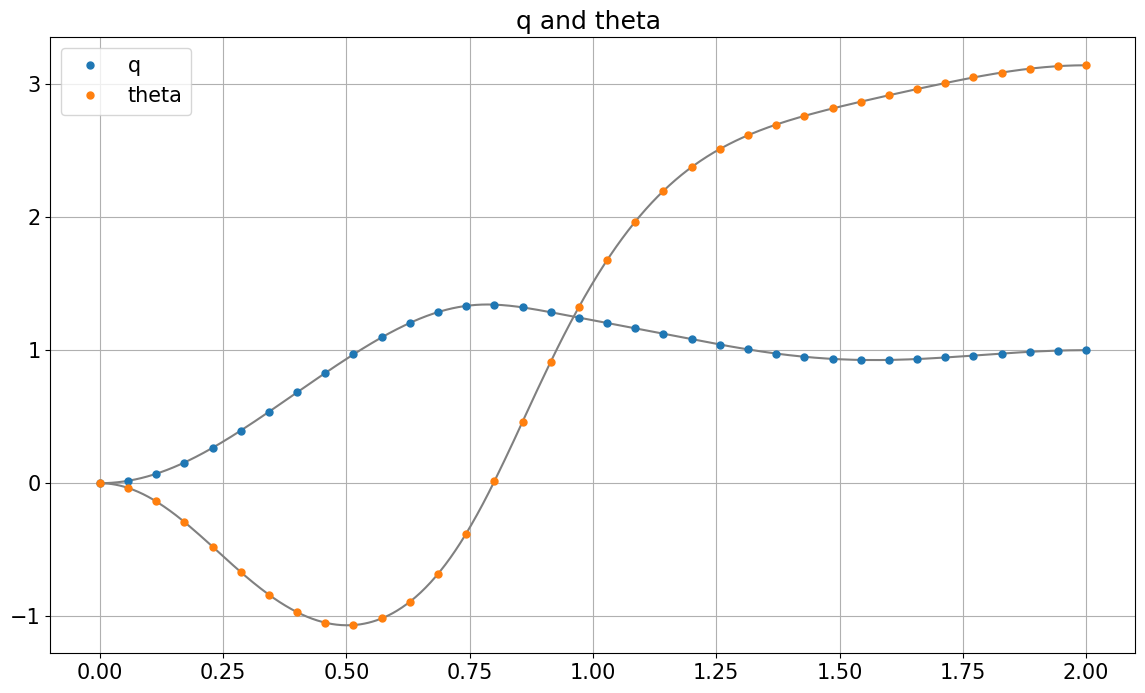

In [151]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(t_interp, q_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

Text(0.5, 1.0, 'q and theta velocities in X')

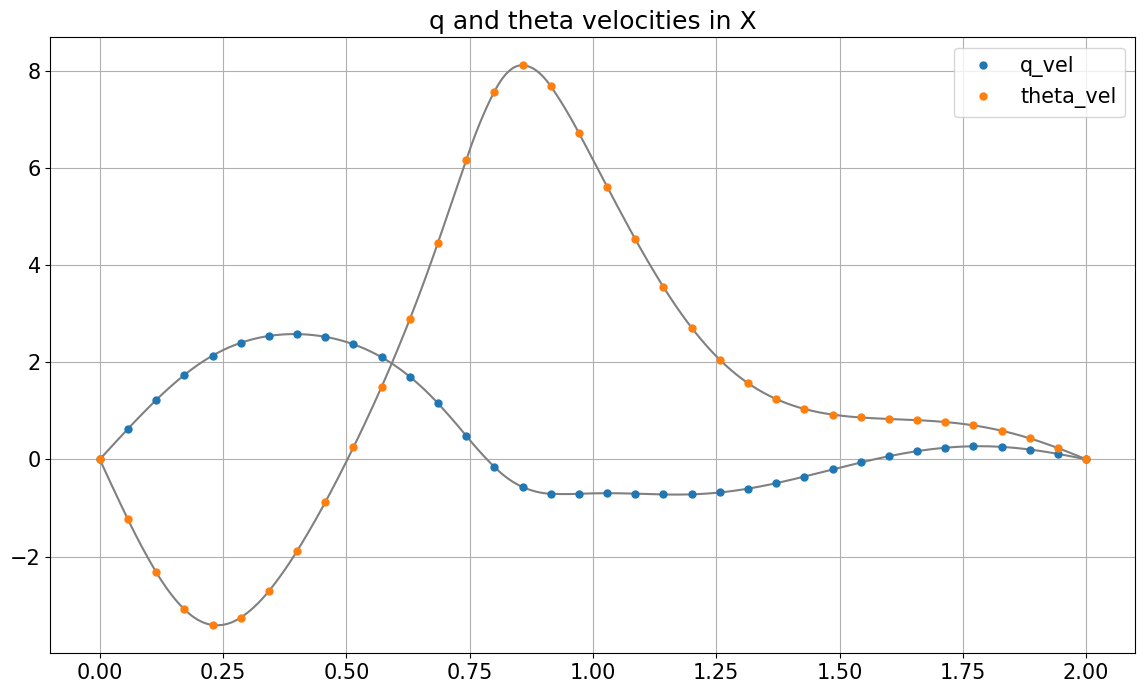

In [152]:
plt.figure(figsize=[14,8])
labels= ['q_vel', 'theta_vel']
for ii in range(2):
    plt.plot(t_interp, v_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['v'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['v_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta velocities in X')

Text(0.5, 1.0, 'q and theta accelerations in X')

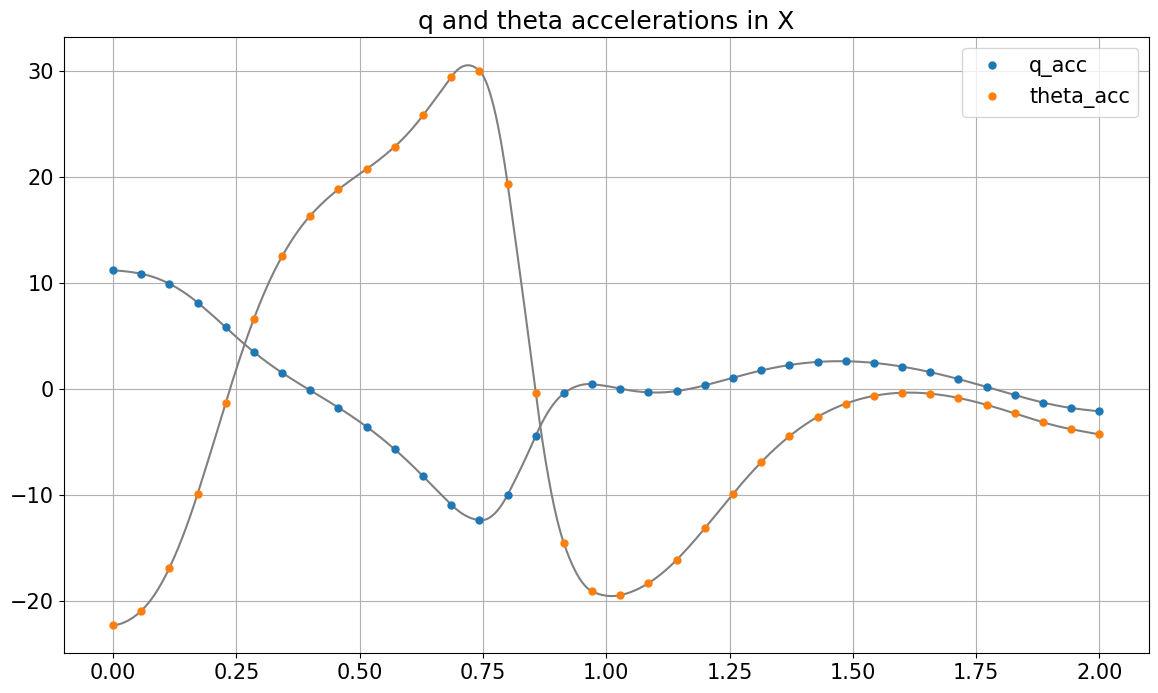

In [153]:
plt.figure(figsize=[14,8])
labels= ['q_acc', 'theta_acc']
for ii in range(2):
    plt.plot(t_interp, a_interp[:,ii], c = 'grey')    
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['a_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta accelerations in X')

Text(0.5, 1.0, 'q and theta Jerk in $ \\dot{X} $')

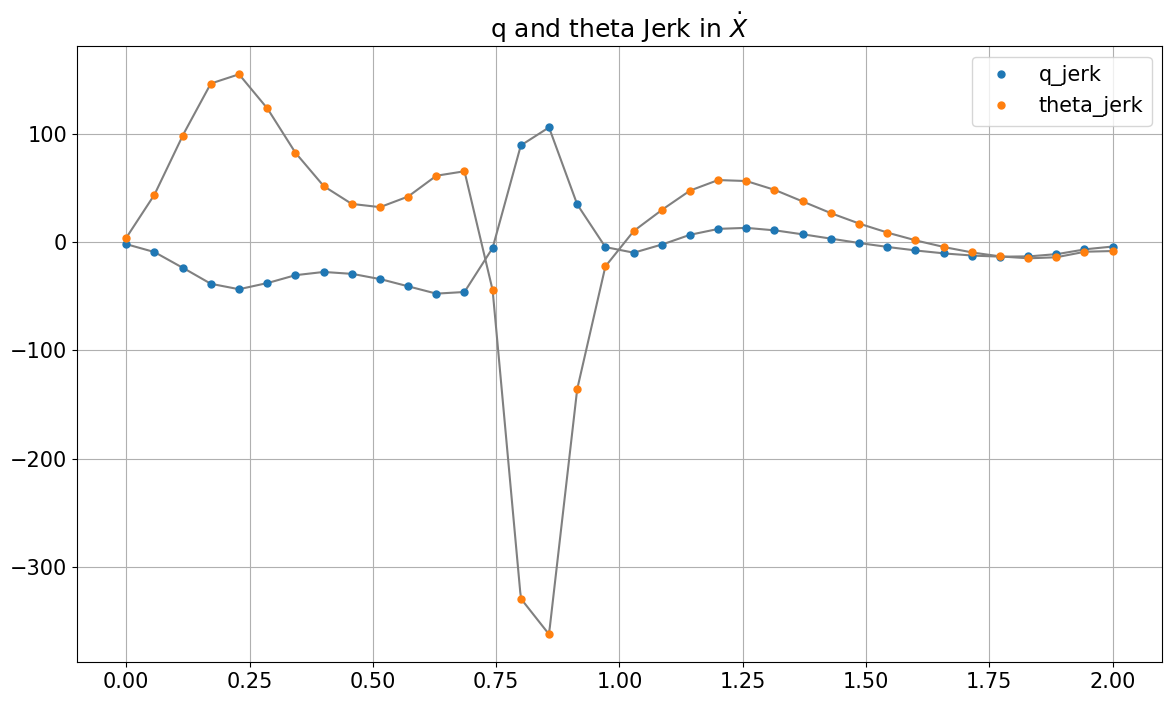

In [154]:
plt.figure(figsize=[14,8])
labels= ['q_jerk', 'theta_jerk']
for ii in range(2):
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii],  'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii],  'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta Jerk in $ \dot{X} $')

Text(0.5, 1.0, 'q and theta interpolation first derivatives')

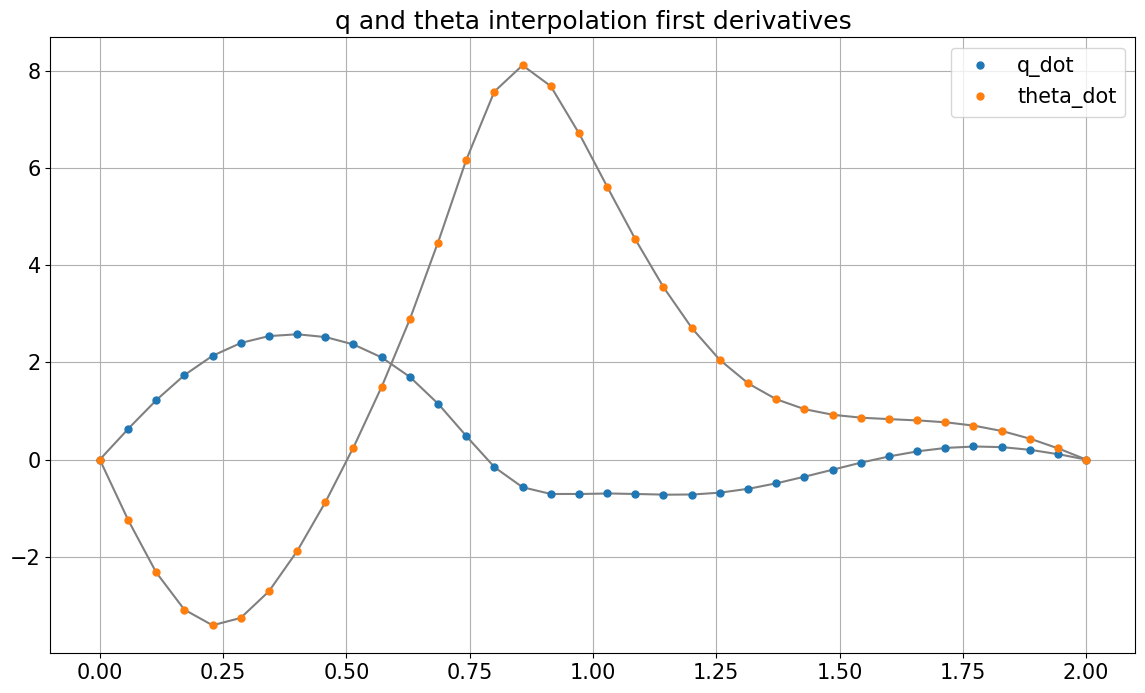

In [155]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(t_interp, q_d_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['v'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation first derivatives')

Text(0.5, 1.0, 'q and theta interpolation second derivatives')

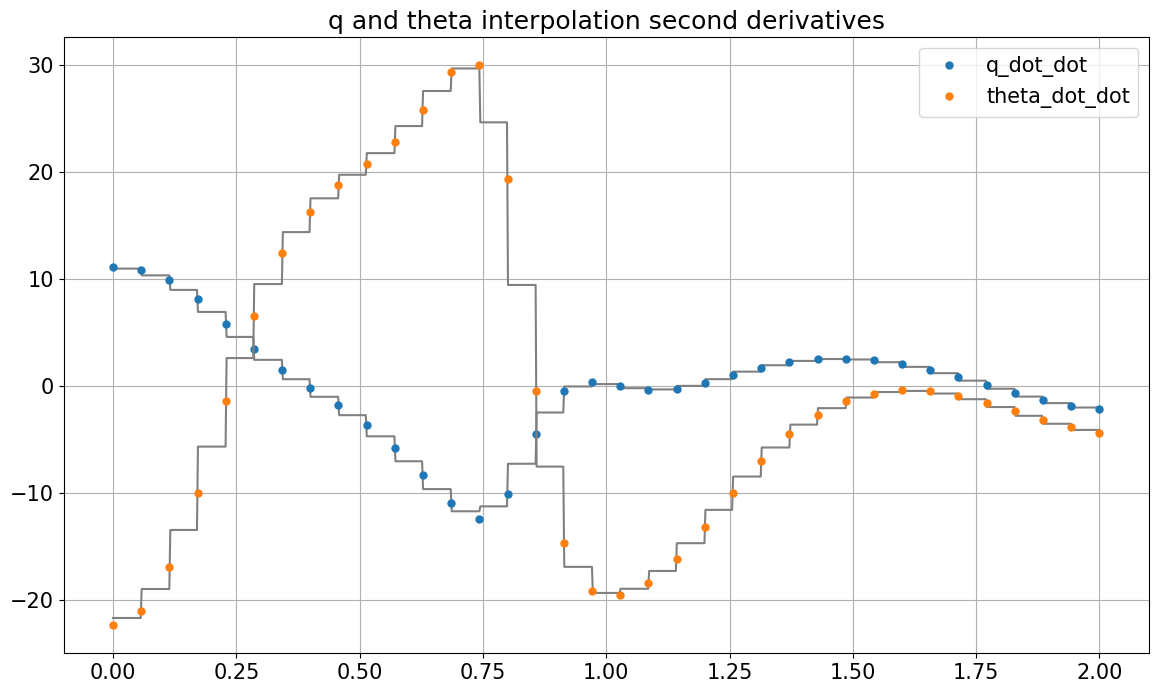

In [156]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(t_interp, q_dd_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['a_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation second derivatives')

Text(0.5, 1.0, 'q and theta interpolation third derivatives')

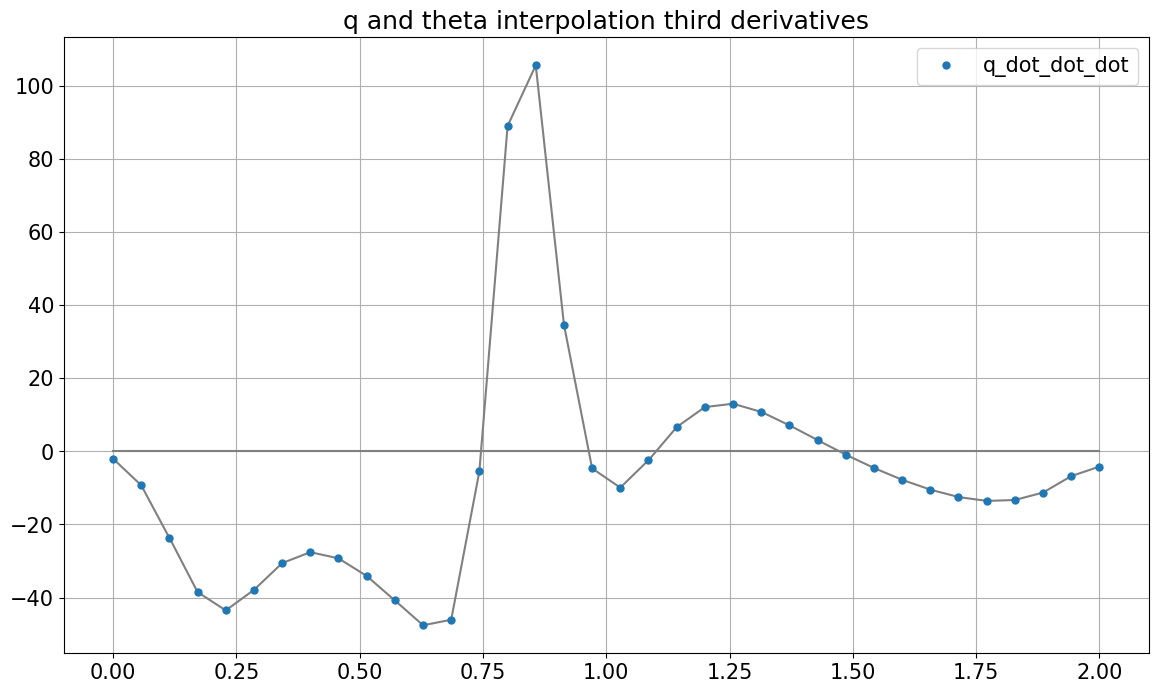

In [157]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot_dot', 'theta_dot_dot_dot']
for ii in range(1):
    plt.plot(t_interp, q_ddd_interp[:,ii], c = 'grey')
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta interpolation third derivatives')

Text(0.5, 1.0, 'u as component of X')

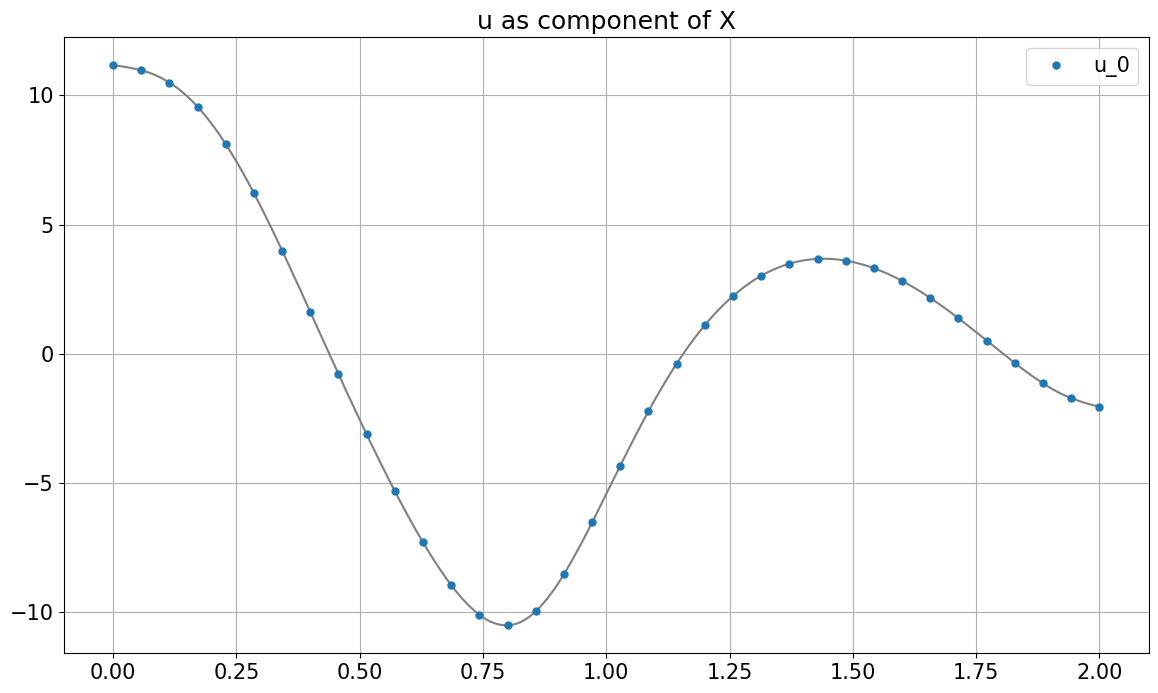

In [158]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(t_interp, a_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['a'][:,ii], 'o', ms =marker_size, label = 'u_0')
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['a_c'][:,ii],  'o', ms =marker_size, label = ' u_c')
plt.grid()
plt.legend()
plt.title('u as component of X')

Text(0.5, 1.0, 'u_dot as component of $\\dot{X}$')

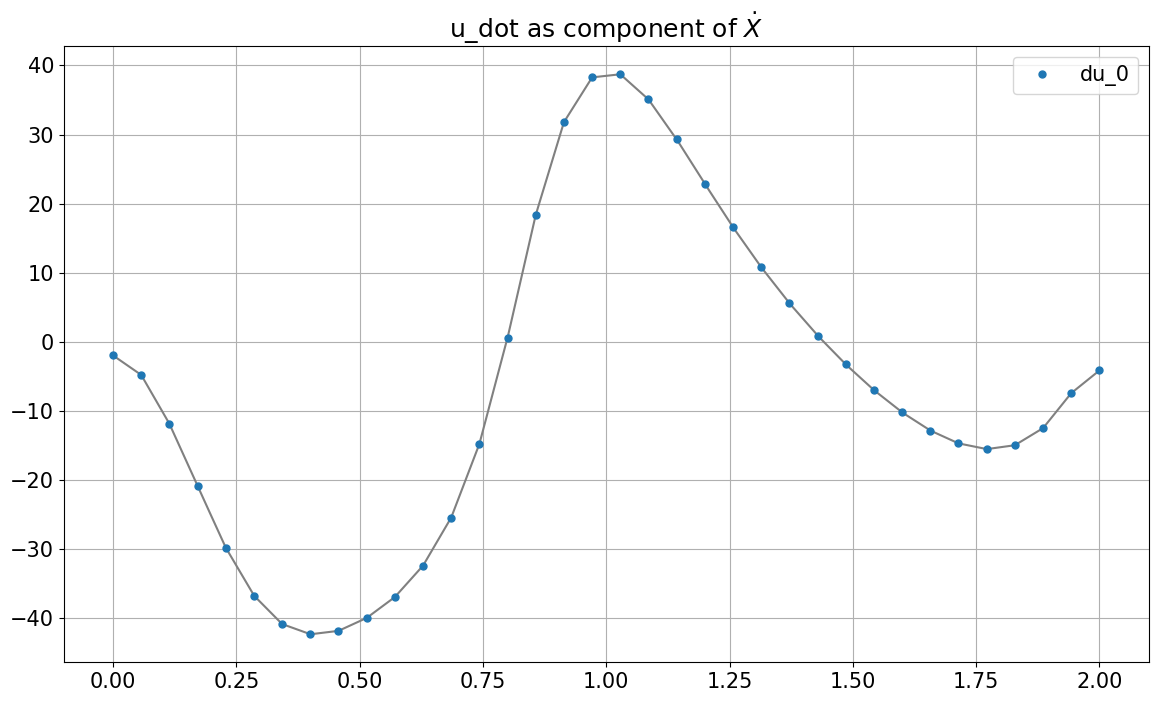

In [159]:
plt.figure(figsize=[14,8])
for ii in [2]:
    plt.plot(t_interp, j_interp[:,ii], c = 'grey')
    plt.plot(_res['t'],_res['jerk'][:,ii],  'o', ms =marker_size, label = 'du_0')
    if 'parab' in scheme:
        plt.plot(_res['t_c'],_res['jerk_c'][:,ii],  'o', ms =marker_size, label = 'du_c')
plt.grid()
plt.legend()
plt.title('u_dot as component of $\dot{X}$')

Text(0.5, 1.0, 'u_dot as w in control')

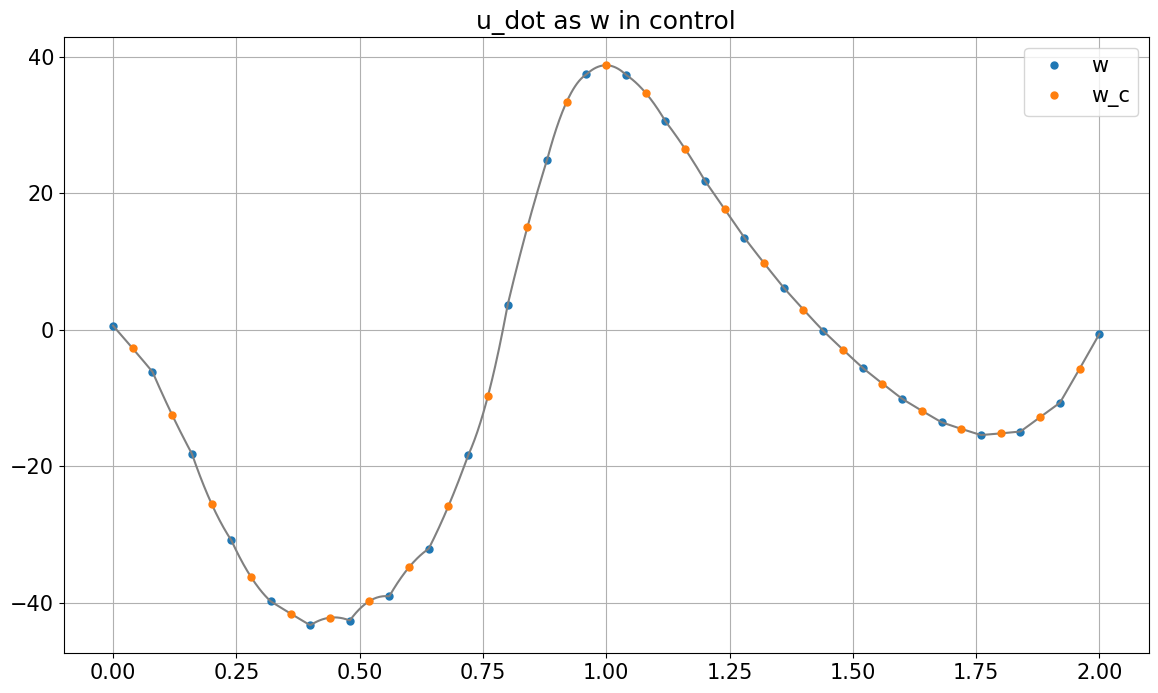

In [114]:
plt.figure(figsize=[14,8])
plt.plot(_res['t'],_res['u'][:],  'o', ms =marker_size, label = 'w')
plt.plot(t_interp, u_interp[:], c = 'grey')
if 'parab' in scheme:
    plt.plot(_res['t_c'],_res['u_c'][:],  'o', ms =marker_size, label = 'w_c')
plt.grid()
plt.legend()

plt.title('u_dot as w in control')

In [115]:
_res['x'][0]

array([  0.        ,   0.        , -34.94417171,   0.        ,
         0.        ,  -8.65640238,  11.02787705, -22.0557541 ,
        11.02787705])

In [116]:
F_nump_w(_res['x'][0], _res['u'][0], params)

array([  0.        ,   0.        ,  -8.65640238,  11.02787705,
       -22.0557541 ,  11.02787705,   0.59513462,  -1.19026924,
         0.59513462])

In [117]:
_res['x_d'][0]

array([  0.        ,   0.        ,  -8.65640238,  11.02787705,
       -22.0557541 ,  11.02787705,   0.59513462,  -1.19026924,
         0.59513462])

In [118]:
_res['cost']

In [119]:
N = 25
scheme = 'hs_parab'

_opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )


_opti.dynamic_setup('f_x_impl', 3, 1, order=3)
_opti.opti_setup(N)
_opti.initial_guess([0,0,0], [1,np.pi,0])
#_opti.sq_cost(_opti.opti_arrs['x'][:,8], _opti.opti_arrs['x_c'][:,8])
_opti.u_sq_cost()
_opti.apply_scheme()


opti = _opti.opti
X = _opti.opti_arrs['x']
U = _opti.opti_arrs['u']
X_s = _opti.opti_points['x_s']
X_e = _opti.opti_points['x_e']

Q_s = X_s[:,:2]
V_s = X_s[:,3:5]
Q_e = X_e[:,:2]
V_e = X_e[:,3:5]
N = _opti.N

# Initial and final conditions
opti.subject_to(Q_s.T == [0, 0])
opti.subject_to(Q_e.T == [1, np.pi])
opti.subject_to(V_s.T == [0, 0])
opti.subject_to(V_e.T == [0, 0])
initial_cond_g(_opti)

# Appliying restrictions and action boundaries
u_m = 100
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

_opti.chrono_solve(solve_repetitions=2,)

_res = _opti.results

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     3742
Number of nonzeros in inequality constraint Jacobian.:       26
Number of nonzeros in Lagrangian Hessian.............:      459

Total number of variables............................:      969
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      919
Total number of inequality constraints...............:       26
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       26
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+01 0.00e+00  -1.0 0.00e

In [120]:
@lru_cache(maxsize=None)
def casadi_cartpole_w(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )


    _opti.dynamic_setup('f_x_impl', 3, 1, order=3)
    _opti.opti_setup(N)
    _opti.initial_guess([0,0,0], [1,np.pi,0])
    #_opti.sq_cost(_opti.opti_arrs['x'][:,8], _opti.opti_arrs['x_c'][:,8])
    _opti.u_sq_cost()
    _opti.apply_scheme()


    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']

    Q_s = X_s[:,:2]
    V_s = X_s[:,3:5]
    Q_e = X_e[:,:2]
    V_e = X_e[:,3:5]

    # Initial and final conditions
    opti.subject_to(Q_s.T == [0, 0])
    opti.subject_to(Q_e.T == [1, np.pi])
    opti.subject_to(V_s.T == [0, 0])
    opti.subject_to(V_e.T == [0, 0])
    initial_cond_g(_opti)

    # Appliying restrictions and action boundaries
    u_m = 100
    for ii in range(N):
        if 'parab' in scheme:
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

    _opti.chrono_solve(solve_repetitions=solve_repetitions,)

    return _opti.results

In [160]:
casadi_cartpole_w('trapz', 35, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True)

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole_w(
            scheme,
            N, 
            'lin',
    1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [121]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [161]:
schemes = ['hs_parab', 'hsn_parab', 'trapz', 'trapz_n'] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 10 #Increase this number to get more reliable values of execution times
#N_arr = [5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50,]
N_arr = [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]# You can increase the numbers here, but it will take more time
results = {}

for scheme in schemes:
    key = scheme
    print('Problem:', key)
    results[key] = {'N_arr':N_arr}
    for N in N_arr:
        print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        results[key][N] = casadi_cartpole_w(
            scheme,
            N, 
            'lin',
            solve_repetitions=solve_repetitions,
            silent=True, 
            verbose=False)


Problem: hs_parab
	N = 20 ,  18:01:34 
	N = 25 ,  18:01:34 
	N = 30 ,  18:01:34 
	N = 40 ,  18:01:34 
	N = 50 ,  18:01:34 
	N = 60 ,  18:01:34 
	N = 80 ,  18:01:34 
	N = 100 ,  18:01:34 
	N = 120 ,  18:01:34 
	N = 160 ,  18:01:34 
	N = 200 ,  18:01:34 
Problem: hsn_parab
	N = 20 ,  18:01:34 
	N = 25 ,  18:01:34 
	N = 30 ,  18:01:34 
	N = 40 ,  18:01:34 
	N = 50 ,  18:01:34 
	N = 60 ,  18:01:34 
	N = 80 ,  18:01:34 
	N = 100 ,  18:01:34 
	N = 120 ,  18:01:34 
	N = 160 ,  18:01:34 
	N = 200 ,  18:01:34 
Problem: trapz
	N = 20 ,  18:01:34 
	N = 25 ,  18:01:34 
	N = 30 ,  18:01:34 
	N = 40 ,  18:01:34 
	N = 50 ,  18:01:34 
	N = 60 ,  18:01:34 
	N = 80 ,  18:01:34 
	N = 100 ,  18:01:34 
	N = 120 ,  18:01:34 
	N = 160 ,  18:01:34 
	N = 200 ,  18:01:34 
Problem: trapz_n
	N = 20 ,  18:01:34 
	N = 25 ,  18:01:34 
	N = 30 ,  18:01:34 
	N = 40 ,  18:01:34 
	N = 50 ,  18:01:34 
	N = 60 ,  18:01:34 
	N = 80 ,  18:01:34 
	N = 100 ,  18:01:34 
	N = 120 ,  18:01:34 
	N = 160 ,  18:01:34 
	N = 200 ,  1

plt.figure(figsize=[14,8])
scheme = 'hs_parab'
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],results['hs_parab'][25]['q'][:,ii], 'o', ms =marker_size, label = labels[ii])
    if 'parab' in scheme: 
        plt.plot(_res['t_c'],results['hs_parab'][25]['q_c'][:,ii], 'o', ms =marker_size, label = labels[ii] + '_c')
plt.grid()
plt.legend()
plt.title('q and theta ')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


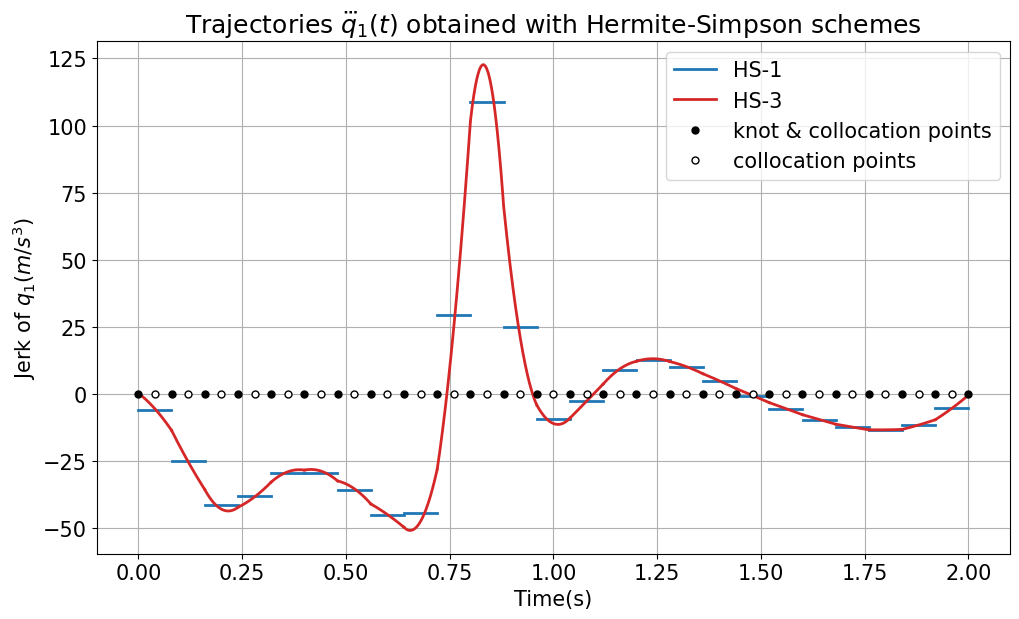

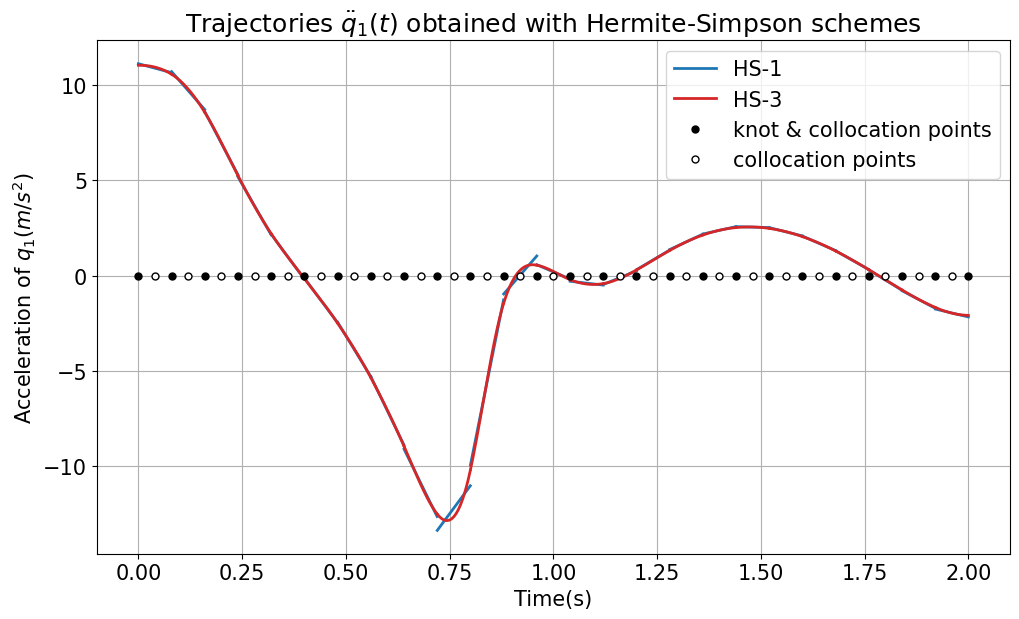

In [162]:
plot_n = 5000
t_interp = np.linspace(0, 2, plot_n)
marker_size = 5
N = 25
dt = (_res['t'][-1]-_res['t'][0])/N

#HS1

_res = results['hs_parab'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs1 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hs_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]

#HS3

_res = results['hsn_parab'][N]
u_scheme = 'parab'
sch_param = {
    'u_c':_res['u_c'],
    "x_dot_c":_res['x_d_c'],
    "order":3}

q_dd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=2,
    scheme_params=sch_param,)[:, :3]

q_ddd_interp_hs3 = interpolated_array_derivative(
    X = _res['x'],
    U = _res['u'],
    h = dt,
    t_array = t_interp,
    params = params,
    F=F_nump_w,
    X_dot=_res['x_d'],
    scheme= 'hsn_parab',
    order=3,
    scheme_params=sch_param,)[:, :3]


schemes_label = ['HS-1', 'HS-3']
schemes_plot = ['hs', 'hsn']
y_plot_list = [q_ddd_interp_hs1[:,0], q_ddd_interp_hs3[:,0]]
y_plot_list_2 = [q_dd_interp_hs1[:,0], q_dd_interp_hs3[:,0]]
plots = [y_plot_list, y_plot_list_2]
y_labels = ["Jerk of $q_1 (m/s^3)$","Acceleration of $q_1 (m/s^2)$"]
_dd = ["ddd", "dd"]

for kk in range(2):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for ii in range(2):

        t_arr = t_interp
        interv_n = (N * t_arr) / _res["t"][-1]
        cut_p = 0
        y_plot = plots[kk][ii]
        scheme = schemes_plot[ii]
        label = schemes_label[ii]
        name = label.replace('HS', 'Hermite-Simpson')
        for ll in range(1, N + 1):
            jj = np.searchsorted(interv_n, ll)
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                "-",
                lw=2,
                c=sch_to_color(scheme),
                label=label if cut_p == 0 else None,
            )
            cut_p = jj
    if "hs" in scheme:
        plot_coll_p = True
    plt.plot(
        _res["t"],
        np.zeros(N + 1),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    if plot_coll_p:
        plt.plot(
            _res["t_c"],
            np.zeros(N),
            "ow",
            ms=5,
            markeredgecolor="k",
            label="collocation points",
        )
    plt.legend()
    plt.grid()
    # plt.ylim([-0.01,y_max_list[ii]])
    plt.title(f"Trajectories $\{_dd[kk]}"+"ot{q}_1(t)$ obtained with Hermite-Simpson schemes")
    plt.xlabel("Time(s)")
    plt.ylabel(y_labels[kk])
    plt.tight_layout(pad=0.0)
    plt.savefig(f'2d_order/Cartpole_deriv_q{_dd[kk]}_HS_schemes_N_{N}.eps', format='eps')

In [163]:
#Calculating the number of collocation points
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']

In [164]:
for scheme in schemes:
    key = scheme
    _c = []
    _cpudt = []
    _iters = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
        _iters.append(results[key][N]['iter_count'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)
    results[key]['iter_count'] = np.array(_iters)

Text(0.5, 1.0, 'Final traj cost')

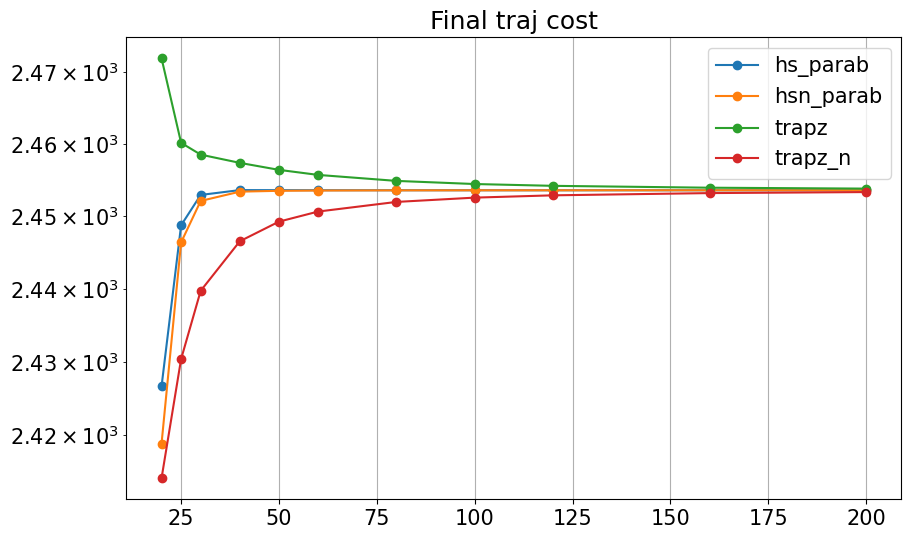

In [165]:
plt.figure(figsize=oct_fig_size)
for scheme in schemes:
    key = scheme
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], marker = 'o', label = scheme)
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [166]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [167]:
#schemes = ['hs_parab', 'hsn_parab', 'trapz', 'trapz_n']
n_interp = 2000
for scheme in schemes:
    key = scheme 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        if 'parab' in scheme:
            u_scheme = 'parab'
            sch_param = {'u_c':results[key][N]['u_c']}
        else:
            u_scheme = 'lin'
            sch_param = {}
        dynamic_errors = dynamic_error(
            results[key][N]['x'],
            results[key][N]['u'],
            2,
            params,
            F_nump_w,
            scheme = scheme,
            u_scheme= u_scheme,
            scheme_params= sch_param,
            n_interp = n_interp,
            order=3,
            mode='q')
        dyn_err_q = dynamic_errors[0][0]
        dyn_err_v = dynamic_errors[0][1]
        dyn_err_2 = dynamic_errors[1][0]
        dyn_err_3 = dynamic_errors[2][0]
        results[key][N]['dyn_err_q'] = dyn_err_q
        results[key][N]['dyn_err_v'] = dyn_err_v
        results[key][N]['dyn_err_2'] = dyn_err_2
        results[key][N]['dyn_err_3'] = dyn_err_3
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        tot_dyn_err_3 = total_state_error(t_arr, dyn_err_3)
        results[key][N]['err_q_int'] = dyn_err_q
        results[key][N]['err_v_int'] = dyn_err_v
        results[key][N]['err_2_int'] = dyn_err_2
        results[key][N]['err_3_int'] = dyn_err_3
        results[key][N]['err_q'] = tot_dyn_err_q
        results[key][N]['err_v'] = tot_dyn_err_v
        results[key][N]['err_2'] = tot_dyn_err_2
        results[key][N]['err_3'] = tot_dyn_err_3
            

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hsn_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_n
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


In [168]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [169]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_v_acum = []
    err_3_acum = []
    cpudt = []
    for N in N_arr:
        err_q_acum.append(results[key][N]['err_q'])
        err_v_acum.append(results[key][N]['err_v'])
        err_3_acum.append(results[key][N]['err_3'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
    results[key]['err_3_acum'] = np.array(err_3_acum, dtype = float)
    

Problem: hs_parab
Problem: hsn_parab
Problem: trapz
Problem: trapz_n


In [170]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_3'].shape[0])
        
        if 'hs' in key:
            scheme_params={'u_c':_case['u_c'],
                          'x_dot_c': _case['x_d_c'],
                          'x_c': _case['x_c'],
                          'order': 3}
        else:
            scheme_params={'order': 3}
            
        _derivs = interpolated_array_derivative(
            _case['x'],
            _case['u'],
            _case['t'][-1]/(_case['t'].shape[0]-1),
            t_array = t_arr,
            params=params,
            F=None,
            X_dot=_case['x_d'],
            scheme=key,
            order=1,
            scheme_params=scheme_params,)
        _accels = _derivs[:, 6:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_3_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_3_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_3']/_case['a_arr'])
        _case['rel_dyn_err_3_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_3_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_3']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_3_arr_by_a_sum_arr_sum'] = None

Problem: hs_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hsn_parab
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_n
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [171]:
from chords.util import plot_by_segments

In [172]:
results[key][N].keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'scheme_mode', 'n_q', 'n_u', 'solve_order', 'params', 'N', 'scheme', 'x', 'x_d', 'x_like_u', 'x_d_like_u', 'u', 'u_like_x', 't', 't_col', 'lam', 'q', 'q_like_u', 'v', 'v_like_u', 'a', 'a_like_u', 'jerk', 'jerk_like_u', 'dyn_err_q', 'dyn_err_v', 'dyn_err_2', 'dyn_err_3', 'err_q_int', 'err_v_int', 'err_2_int', 'err_3_int', 'err_q', 'err_v', 'err_2', 'err_3', 'sum_dyn_err_3_arr', 'a_arr', 'a_abs_mean_by_component', 'a_abs_mean', 'a_abs_sum_arr', 'rel_dyn_err_3_arr_by_instant_a_sum', 'rel_dyn_err_3_arr_by_total_mean_sum', 'rel_dyn_err_3_arr_by_mean_by_component_sum', 'rel_dyn_err_3_arr_by_a_sum_arr_sum'])

In [173]:
results['trapz'][50]['t'].shape

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


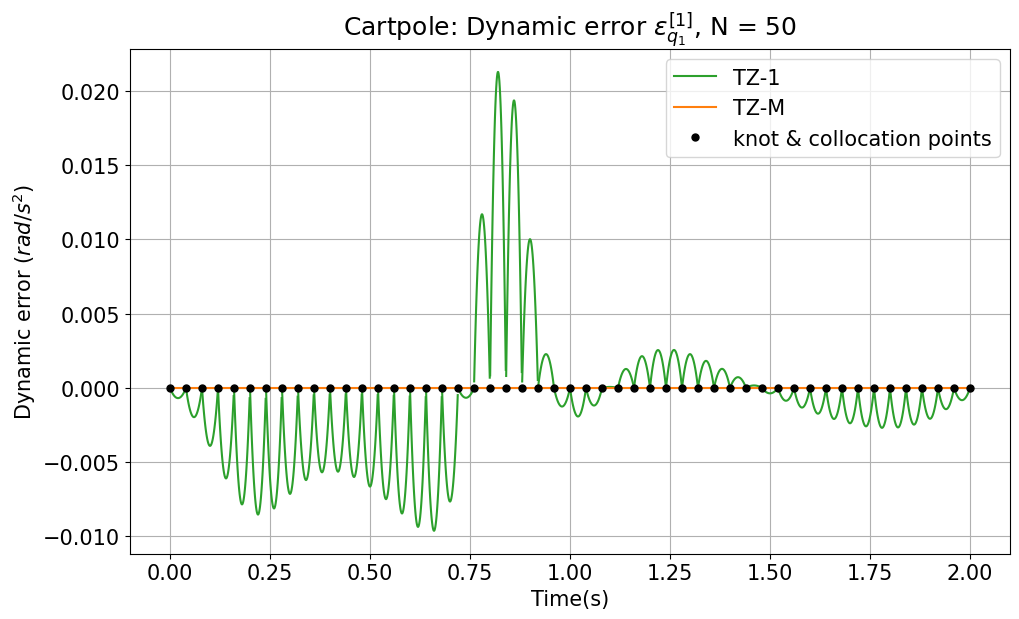

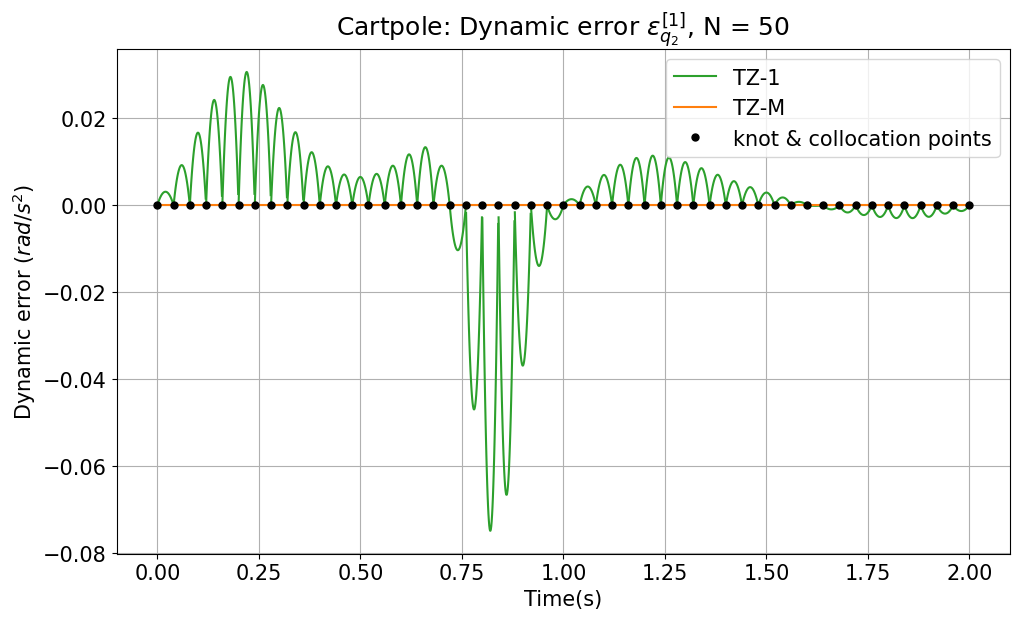

In [174]:
schemes = ['trapz', 'trapz_n']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_First_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


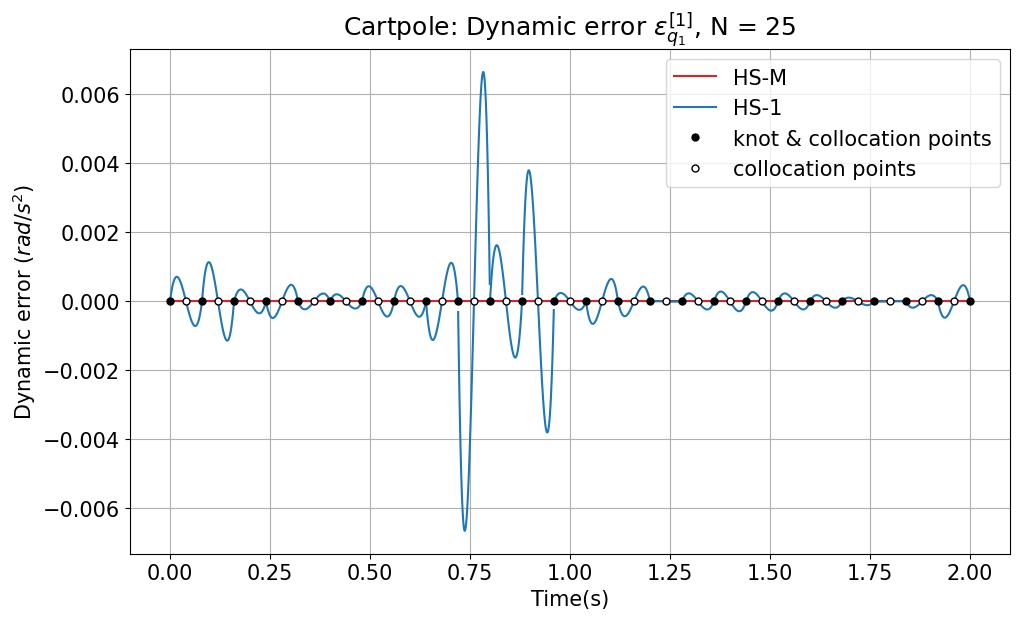

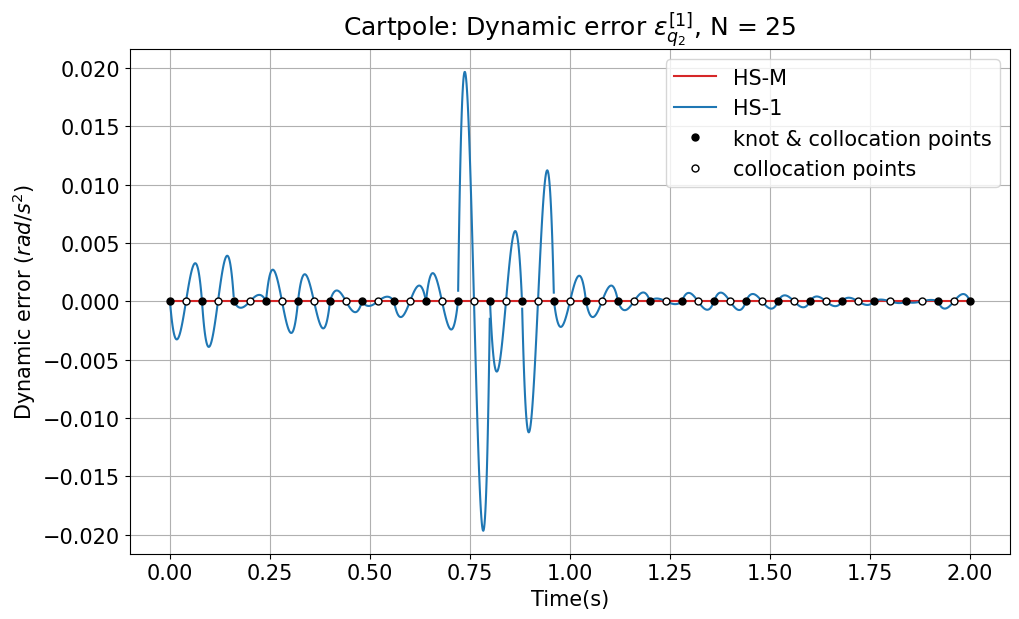

In [175]:
schemes = ['hsn_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_q',
        title = r'Cartpole: Dynamic error $\varepsilon^{[1]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_First_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


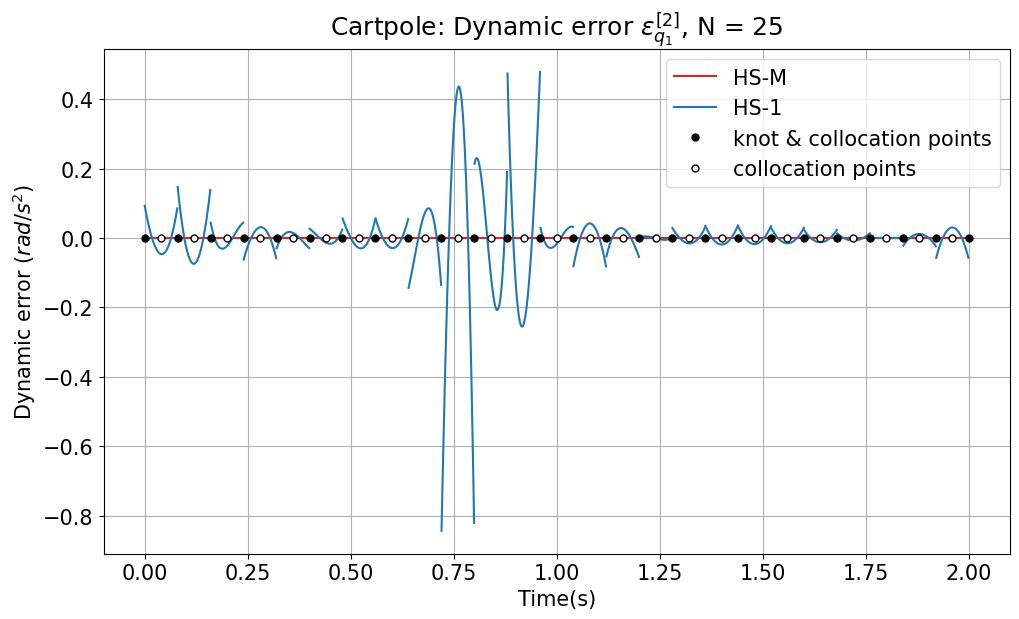

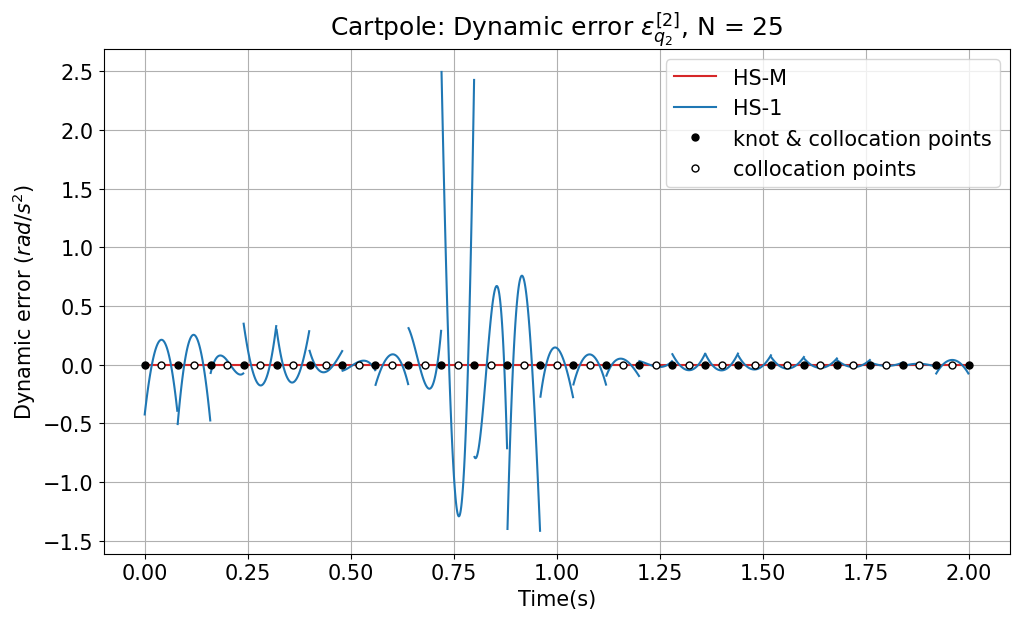

In [176]:
schemes = ['hsn_parab','hs_parab']
N = 25
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_Second_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


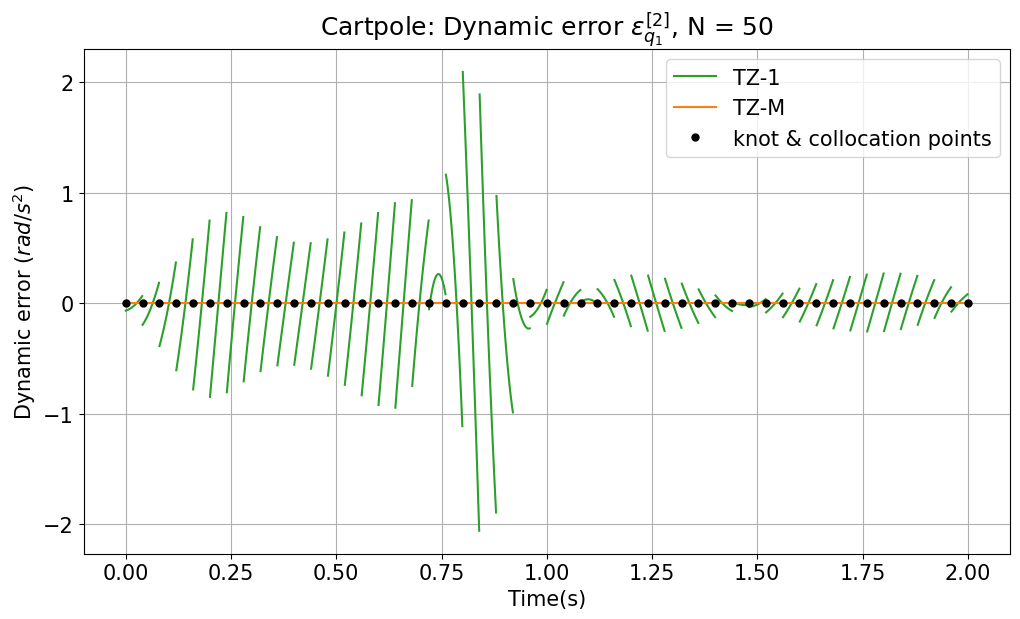

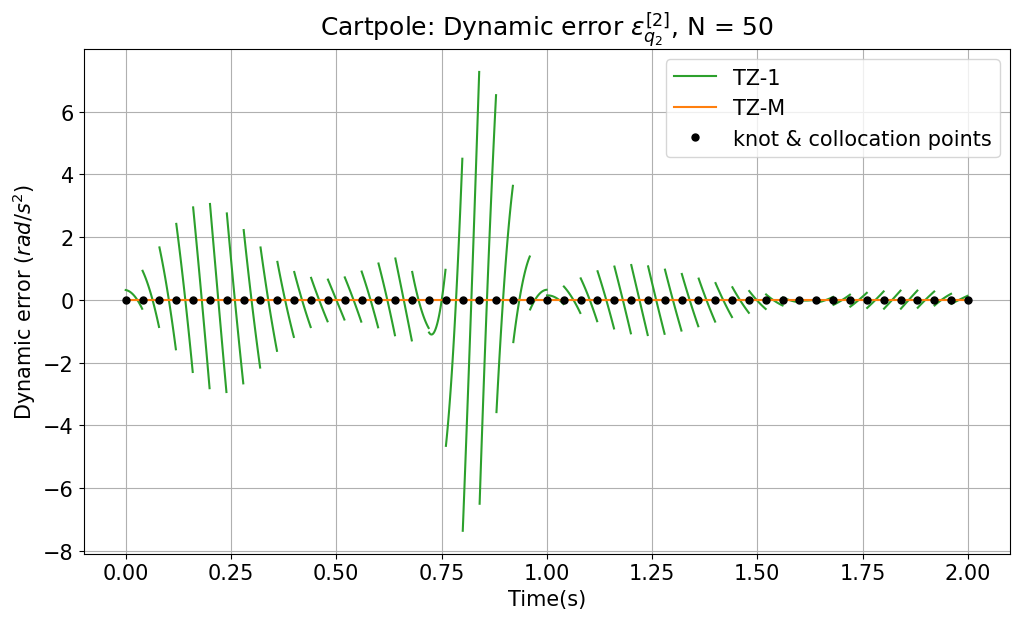

In [177]:
schemes = ['trapz', 'trapz_n']
N = 50
for component in range(2):
    plot_by_segments(results, schemes, N,
        thing_to_plot = 'dyn_err_2',
        title = r'Cartpole: Dynamic error $\varepsilon^{[2]}_{q_'+f'{component+1}}}$, N = {N}',
        ylabel = 'Dynamic error $(rad/s^2)$',
        component = component)
    plt.savefig(f'2d_order/Cartpole_deriv_Second_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

#### Relative Errors

In [178]:
error_types = ['rel_dyn_err_3_arr_by_instant_a_sum',
 'rel_dyn_err_3_arr_by_mean_by_component_sum',]
error_titles = [error.replace('rel_dyn_err_3_arr_', '').replace('_', ' ')[:-4] for error in error_types]

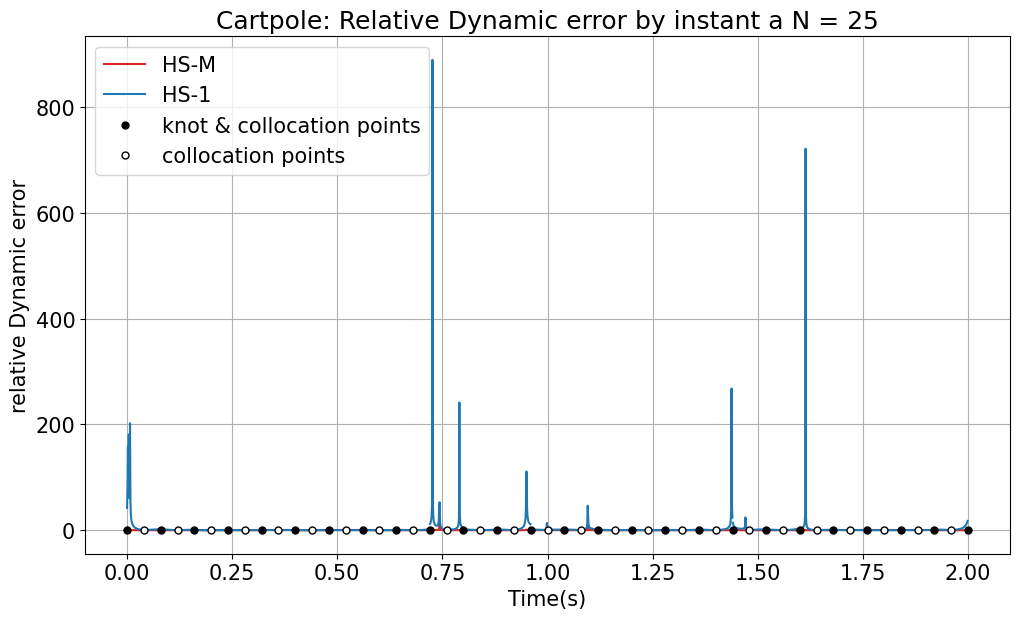

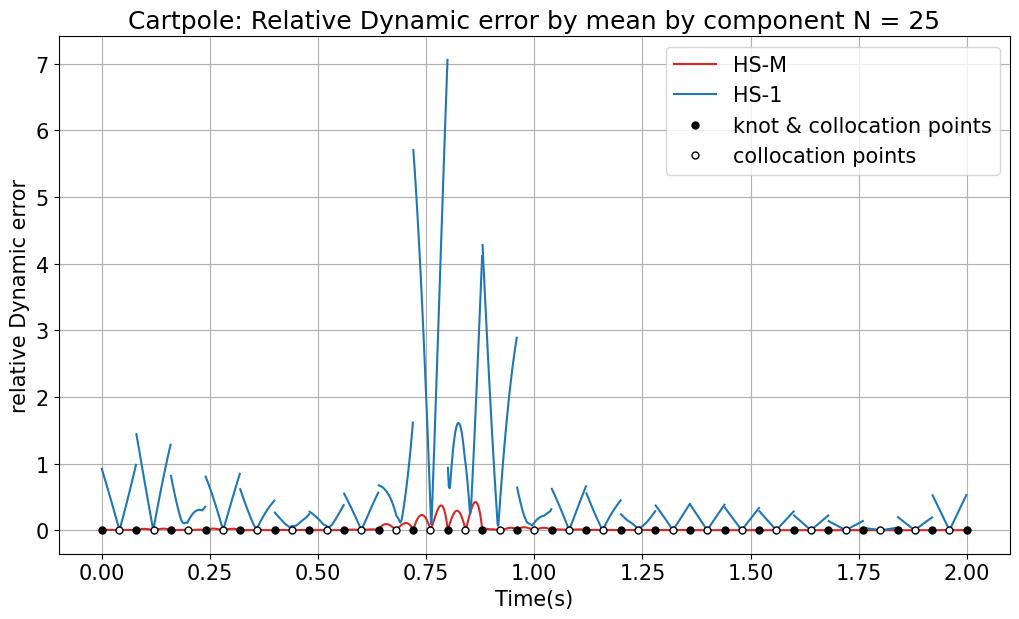

In [179]:
schemes = ['hsn_parab','hs_parab']
N = 25
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

In [180]:
for scheme in results.keys():
    _n = 25 if 'hs' in scheme else 50
    _e = results[scheme][_n]['rel_dyn_err_3_arr_by_mean_by_component_sum']
    print(f'scheme {scheme.ljust(12)} N {_n} avg {round(np.mean(_e), 4)} max {round(np.max(_e), 3)}')

scheme hs_parab     N 25 avg 0.4888 max 7.055
scheme hsn_parab    N 25 avg 0.0235 max 0.423
scheme trapz        N 50 avg 3.014 max 12.723
scheme trapz_n      N 50 avg 0.0486 max 0.985


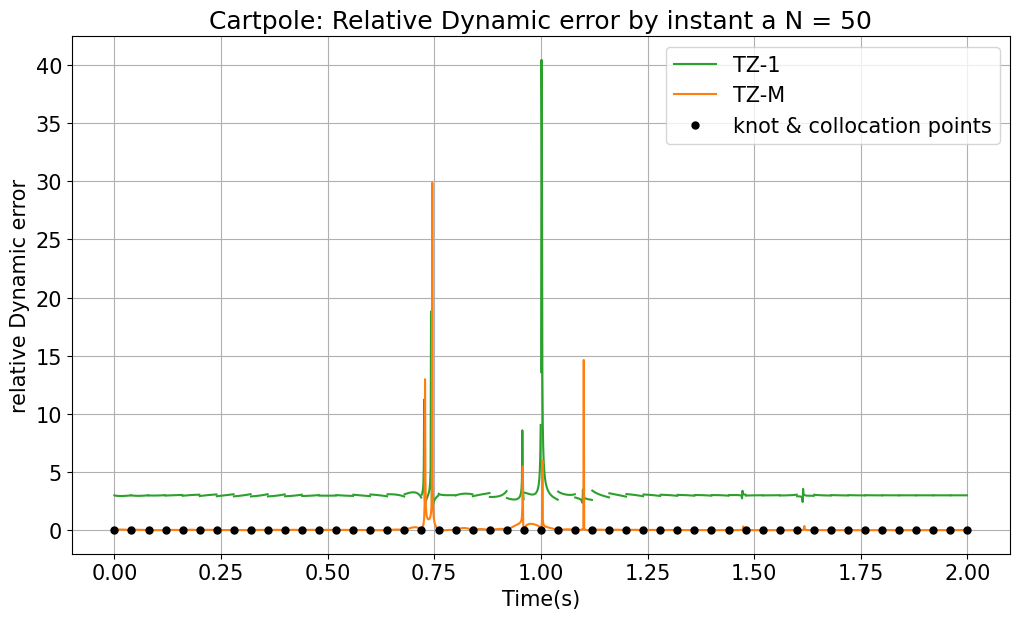

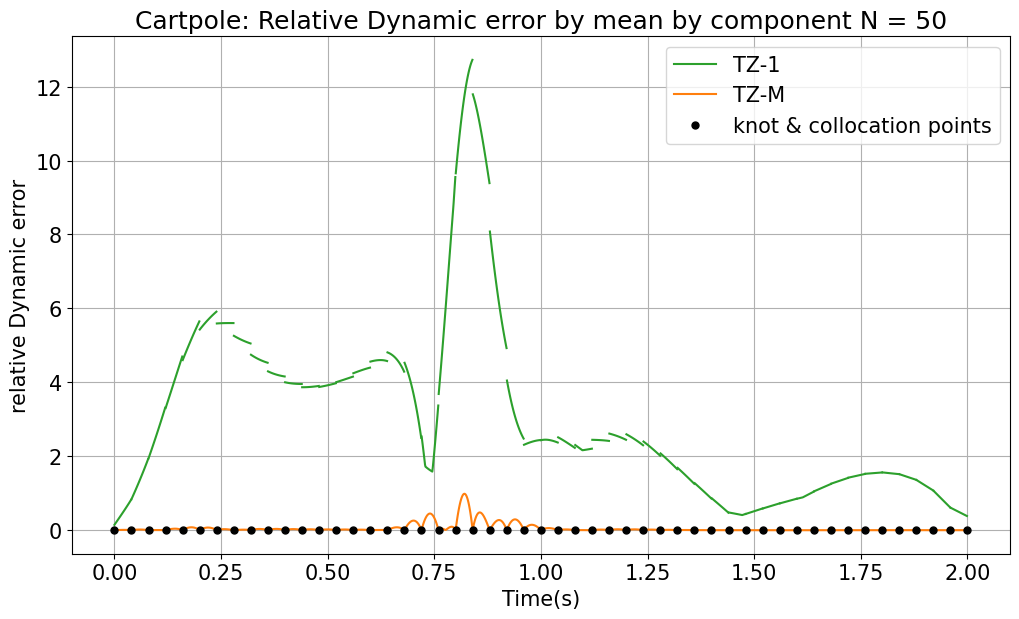

In [181]:
schemes = ['trapz', 'trapz_n']
N = 50
for ii in range(len(error_types)):
    error_type = error_types[ii]
    err_title = error_titles[ii]
    plot_by_segments(results, schemes, N,
                 thing_to_plot = error_type,
                 title = r'Cartpole: Relative Dynamic error ' + err_title +f' N = {N}',
                 ylabel = 'relative Dynamic error')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


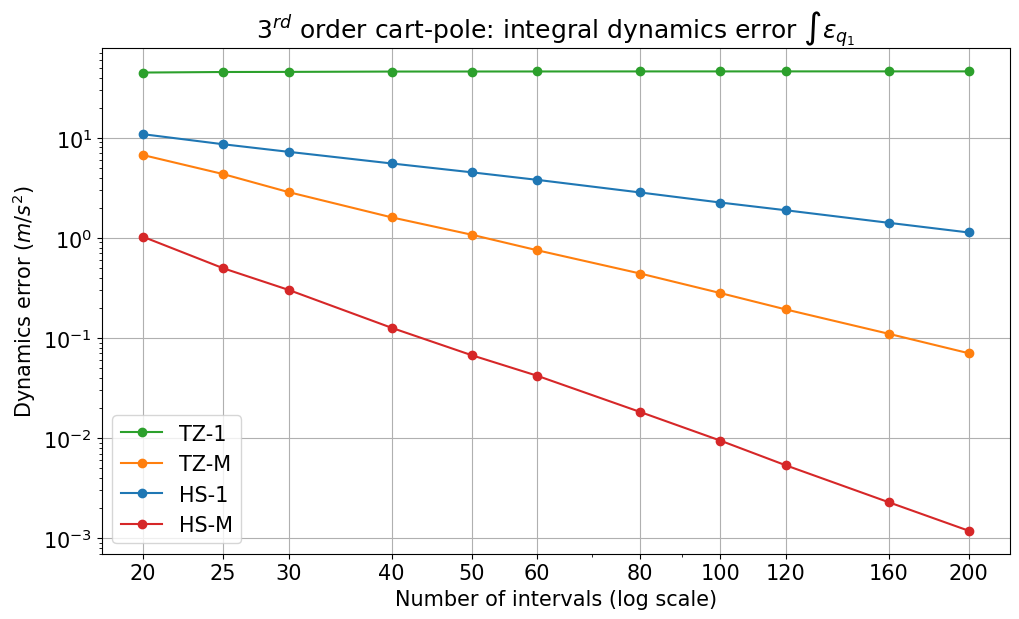

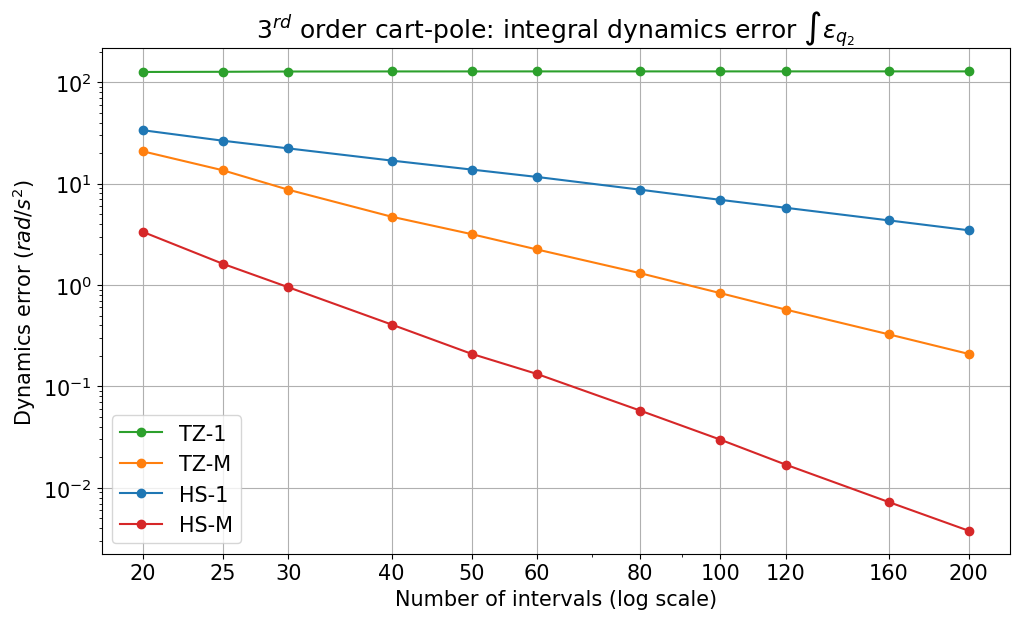

In [182]:
data_array = ['err_q_acum','err_v_acum','err_3_acum','cpudt']
schemes = ['trapz', 'trapz_n','hs_parab', 'hsn_parab',]

data_key = data_array[2]

for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'$3^{rd}$ order cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in schemes:
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **scheme_kwargs(key, longlabel=False))
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **scheme_kwargs(key, longlabel=False))
    plt.yscale('log')
    plt.xscale('log')
    ticks = np.array(results[key]['N_arr'])
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of intervals (log scale)')
    plt.grid()
    plt.legend()
    units = 'm/s^2' if qq == 0 else'rad/s^2'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    plt.savefig(f'2d_order/Cartpole_deriv_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


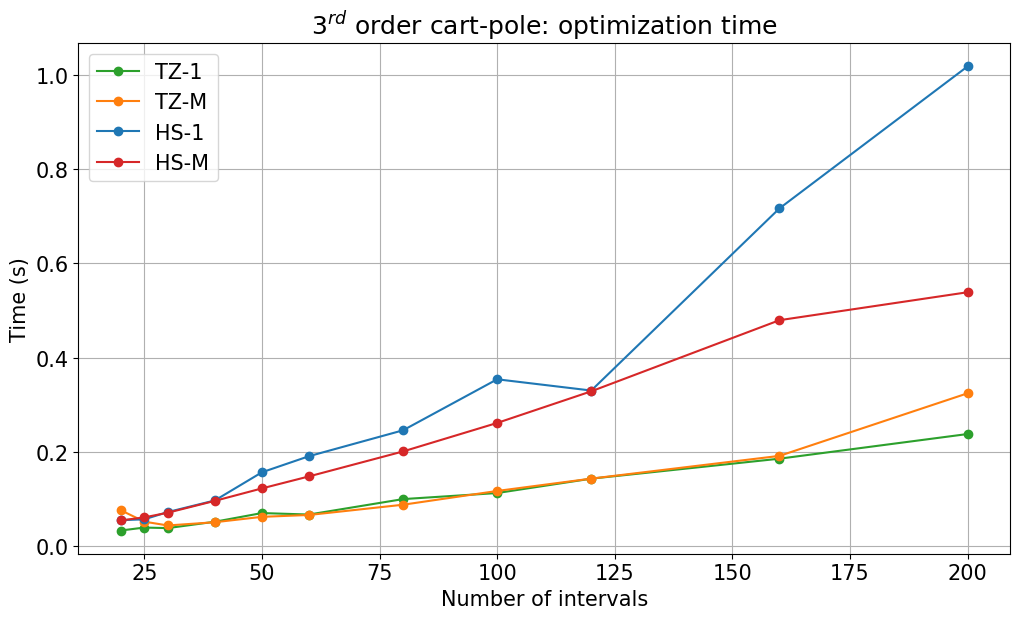

In [183]:
schemes = ['hsn_parab','hs_parab', 'trapz', 'trapz_n']
titles = ['Nth order Hermite Simpson', 'Hermite Simpson','Trapezoidal', 'Nth order Trapezoidal']
plt.figure(figsize=[10,6])
for ii in [2,3,1,0]:
    key = schemes[ii]
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.title('$3^{rd}$ order cart-pole: optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
plt.savefig(f'2d_order/Cartpole_deriv_optimization_time_vs_interval_number.eps', format='eps')

In [184]:
# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_n', 'hs_parab', 'hsn_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 3:', results[key][N]['err_3'])

scheme: trapz N: 50 
	time: 0.07022850513458252 
	Err 1: [0.00600287 0.01692456 0.00553843] 
	Err 3: [ 45.92567234 127.61383436  41.54265449]
scheme: trapz_n N: 50 
	time: 0.06221530437469482 
	Err 1: [1.41016791e-21 5.26101104e-21 0.00000000e+00] 
	Err 3: [1.07516699e+00 3.17356971e+00 5.19726277e-15]
scheme: hs_parab N: 25 
	time: 0.05693488121032715 
	Err 1: [0.00106544 0.00330027 0.00051309] 
	Err 3: [ 8.61437612 26.45103836  3.89398816]
scheme: hsn_parab N: 25 
	time: 0.06102080345153808 
	Err 1: [2.40483886e-10 2.05999086e-09 0.00000000e+00] 
	Err 3: [4.97150097e-01 1.61584160e+00 7.03740606e-16]


## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)